In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Cambiar al directorio donde se encuentra el dataset
dataset_path = '/content/drive/My Drive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos'
os.listdir(dataset_path)  # Verifica los archivos en el directorio

Mounted at /content/drive


['readme.md',
 'Lexique - Data Analyst.xlsx',
 'extract - cash request - data analyst.csv',
 'extract - fees - data analyst - .csv',
 'extract - cash request - data analyst.gsheet',
 'extract - fees - data analyst - .gsheet',
 'payments_manager.py']

In [3]:
# Cargar el dataset principal de solicitudes de adelanto en efectivo
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
# Crear una copia del DataFrame para preservar el original
cr = credit_requests.copy()

# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')
# Crear una copia del DataFrame para preservar el original
fs = fees.copy()

In [4]:
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cr.fillna({"user_id": cr["deleted_account_id"]}, inplace=True)

In [5]:
# Convertir 'created_at' a tipo datetime para manipulación de fechas
cr['created_at'] = pd.to_datetime(cr['created_at'])
cr.head()

# Convertir la columna 'created_at' en fees a tipo datetime para análisis temporal
fs['created_at'] = pd.to_datetime(fs['created_at'])
fs.head()

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150+00:00,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,NaN,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653+00:00,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,NaN,after
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972+00:00,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,NaN,after
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958+00:00,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,NaN,after
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432+00:00,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,NaN,after


In [6]:
# Convertir la columna 'created_at' a una fecha sin zona horaria
cr['created_at'] = cr['created_at'].dt.tz_localize(None)
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN


In [7]:
# Crear columna 'Mes' indicando el mes de cada solicitud
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-05


In [8]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
cr.head(10)

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-05,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,2020-07-06 03:36:03.023911+00,9489.0,2020-05-24 12:40:33.05491+00,NaN,2020-06-06 22:00:00+00,2020-05-26,2020-07-06 03:36:03.023521+00,regular,NaN,completed,2020-06-12 22:27:04.837525+00,2020-07-06 03:36:03.030904+00,2020-05,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,2020-06-17 10:21:21.364746+00,14631.0,2020-06-17 10:21:21.360742+00,NaN,2020-07-11 23:51:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-06,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,2020-02-10 11:53:32.104131+00,309.0,2020-02-10 09:11:21.350695+00,309.0,2020-03-11 01:11:53.80793+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-02,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,2020-06-28 12:06:33.712853+00,2499.0,NaN,2499.0,2020-07-07 22:00:00+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2020-06,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,2019-12-12 15:06:11.192888+00,897.0,2019-12-12 15:06:11.190299+00,NaN,2019-12-17 19:51:23.910748+00,NaN,NaN,regular,NaN,NaN,NaN,NaN,2019-12,2019-12


In [9]:
# Calcular el número inicial de clientes únicos en cada cohorte
cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_Clientes_Iniciales=('user_id', 'nunique')).reset_index()
cohort_sizes_initial

,Cohorte,Num_Clientes_Iniciales
0,2019-11,1
1,2019-12,254
2,2020-01,106
3,2020-02,90
4,2020-03,86
5,2020-04,246
6,2020-05,432
7,2020-06,1540
8,2020-07,1482
9,2020-08,728


In [10]:
# Calcular la cantidad de clientes únicos en cada cohorte para cada mes
cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
78,2020-09,2020-10,680
79,2020-09,2020-11,20
80,2020-10,2020-10,4802
81,2020-10,2020-11,15


In [11]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()

,id,amount,status,created_at,updated_at,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,Mes,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.40783+00,804.0,2019-12-11 16:47:42.405646+00,NaN,2020-01-09 19:05:21.596363+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054+00,231.0,2019-12-11 14:24:22.897988+00,NaN,2020-01-09 19:50:12.34778+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773+00,191.0,2019-12-11 09:46:59.777728+00,NaN,2020-01-09 19:13:35.825041+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163+00,761.0,2019-12-18 14:26:18.128407+00,NaN,2020-01-09 19:16:10.879606+00,NaN,...,regular,NaN,NaN,NaN,NaN,2019-12,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.34008+00,7686.0,2020-05-07 09:21:55.320193+00,NaN,2020-06-05 22:00:00+00,NaN,...,regular,NaN,NaN,NaN,NaN,2020-05,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [12]:
# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')
cohort_revenue

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


In [13]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes


# Agregar columnas de temporalidad
# Semana y mes de la solicitud
cr['Semana_Mes'] = cr['created_at'].dt.strftime('%U_%B') + '_' + cr['Mes'].dt.strftime('%Y')
# Día y semana de la solicitud
cr['Dia_Semana'] = cr['created_at'].dt.strftime('%A') + '_' + cr['Semana_Mes']
# Hora y dia de la solicitud
cr['Hora_Dia'] = cr['created_at'].dt.hour.astype(str) + '_' + cr['Dia_Semana']
cr.head()


# Calcular la cantidad de adelanto de efectivo por cohorte y mes
cohort_revenue = cr.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()
cohort_revenue = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

cohort_revenue

Mes,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11
Cohorte,,,,,,,,,,,,,
2019-11,1.0,100.0,NaN,NaN,NaN,100.0,10.0,NaN,NaN,10.0,5.0,6.0,NaN
2019-12,NaN,27197.0,10123.0,5881.0,7650.0,7900.0,8175.0,8805.0,6990.0,7790.0,4860.0,6655.0,100.0
2020-01,NaN,NaN,11464.0,2360.0,1660.0,3500.0,3020.0,2770.0,3010.0,2150.0,1970.0,2350.0,100.0
2020-02,NaN,NaN,NaN,8412.0,4740.0,4607.0,4350.0,4235.0,4405.0,4130.0,2555.0,3595.0,NaN
2020-03,NaN,NaN,NaN,NaN,9499.0,4250.0,4540.0,4850.0,4055.0,3390.0,2800.0,2700.0,50.0
2020-04,NaN,NaN,NaN,NaN,NaN,25736.0,14258.0,14320.0,11000.0,9915.0,7685.0,6450.0,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,44883.0,30143.0,25725.0,21224.0,16350.0,15305.0,350.0
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180903.0,92672.0,84491.0,60025.0,56525.0,400.0
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180330.0,76873.0,49725.0,47313.0,500.0


## PRIMER MODELO

Precisión del modelo en datos de prueba: -5.4032


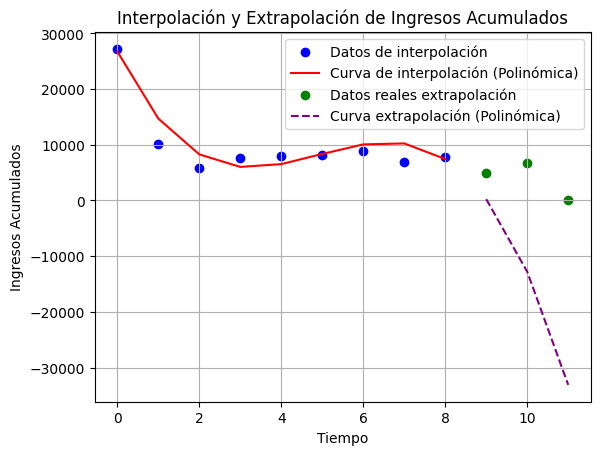

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
n_total = len(datos_no_nulos)

# División de los datos
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = np.array(range(len(datos_interpolacion))).reshape(-1, 1)
y_interpolacion = datos_interpolacion.values

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = np.array(range(n_interpolacion, n_total)).reshape(-1, 1)
y_extrapolacion = datos_extrapolacion.values

# Transformar los datos para ajustar un modelo polinómico de grado 3
poly = PolynomialFeatures(degree=3)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(x_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(x_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')

# Graficar los datos de extrapolación
plt.scatter(x_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(x_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')

# Configuración del gráfico
plt.xlabel('Tiempo')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.legend()
plt.grid()
plt.show()

Precisión del modelo en datos de prueba: 0.5589


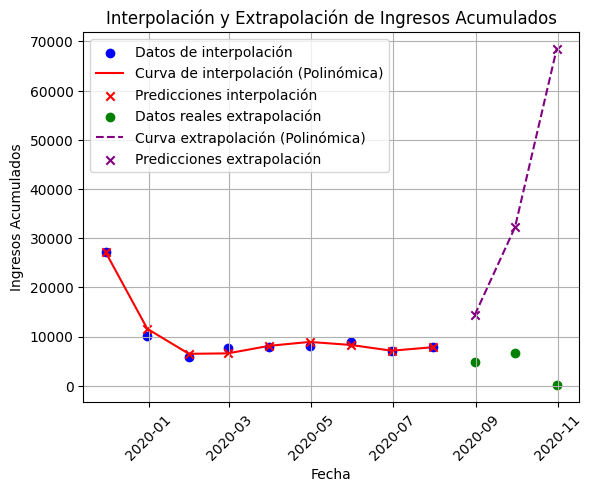

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo en datos de prueba (R^2): 0.5589
Error Cuadrático Medio (MSE): 1082446.0534
Raíz del Error Cuadrático Medio (RMSE): 1040.4067


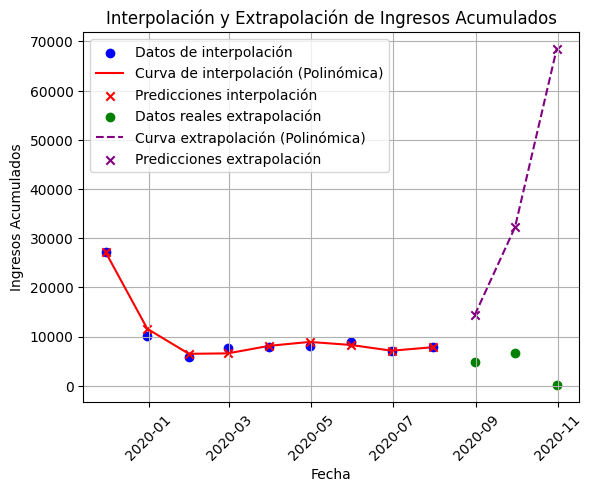

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Escalar los datos (opcional, puede mejorar la precisión en modelos polinómicos)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en los datos de prueba
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba (R^2): {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(scaler.transform(x_interpolacion))
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(scaler.transform(x_extrapolacion))
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el MSE
mse = mean_squared_error(y_test, modelo.predict(x_test_poly))
rmse = np.sqrt(mse)
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [18]:
# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = modelo.predict(x_train_poly)
y_test_pred = modelo.predict(x_test_poly)

# Cálculo de métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Error Cuadrático Medio (MSE) - Entrenamiento: {mse_train:.4f}')
print(f'Coeficiente de Determinación (R²) - Entrenamiento: {r2_train:.4f}')
print(f'Error Cuadrático Medio (MSE) - Prueba: {mse_test:.4f}')
print(f'Coeficiente de Determinación (R²) - Prueba: {r2_test:.4f}')

NameError: name 'r2_score' is not defined

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Escalar los datos (opcional, puede mejorar la precisión en modelos polinómicos)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión polinómica y entrenarlo
modelo = LinearRegression()
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en los datos de prueba
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba (R^2): {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(scaler.transform(x_interpolacion))
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(scaler.transform(x_extrapolacion))
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)


######################
# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = modelo.predict(x_train_poly)
y_test_pred = modelo.predict(x_test_poly)

# Cálculo de métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados

print(f'Coeficiente de Determinación (R²) - Entrenamiento: {r2_train:.4f}')
print(f'Coeficiente de Determinación (R²) - Prueba: {r2_test:.4f}')
print(f'Error Cuadrático Medio (MSE) - Entrenamiento: {mse_train:.4f}')
print(f'Error Cuadrático Medio (MSE) - Prueba: {mse_test:.4f}')

#####################


# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Polinómica)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Polinómica)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo en datos de prueba (R^2): 0.5589


NameError: name 'r2_score' is not defined

### Pruebas para mejorar

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-4, 1, 10)}  # Prueba valores entre 0.0001 y 10
grid_search = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
grid_search.fit(x_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']
modelo = Ridge(alpha=best_alpha)
modelo.fit(x_train_poly, y_train)

NameError: name 'Ridge' is not defined

In [21]:
for degree in range(2, 6):
    poly = PolynomialFeatures(degree=degree)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)

    modelo = Ridge(alpha=0.042)
    modelo.fit(x_train_poly, y_train)

    r2_test = modelo.score(x_test_poly, y_test)
    print(f'Grado {degree} - R² en prueba: {r2_test:.4f}')

NameError: name 'Ridge' is not defined

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

modelo = Ridge(alpha=0.0001)
modelo.fit(x_train_poly, y_train)

NameError: name 'Ridge' is not defined

In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(Ridge(alpha=0.042), x_train_poly, y_train, cv=5, scoring='r2')
print(f'R² promedio en validación cruzada: {np.mean(scores):.4f}')

NameError: name 'Ridge' is not defined

### Pruebas 2

R² promedio en validación cruzada: nan
Coeficiente de Determinación (R²) - Entrenamiento: 0.9928
Coeficiente de Determinación (R²) - Prueba: 0.5583
Error Cuadrático Medio (MSE) - Entrenamiento: 339594.5122
Error Cuadrático Medio (MSE) - Prueba: 1083914.0406


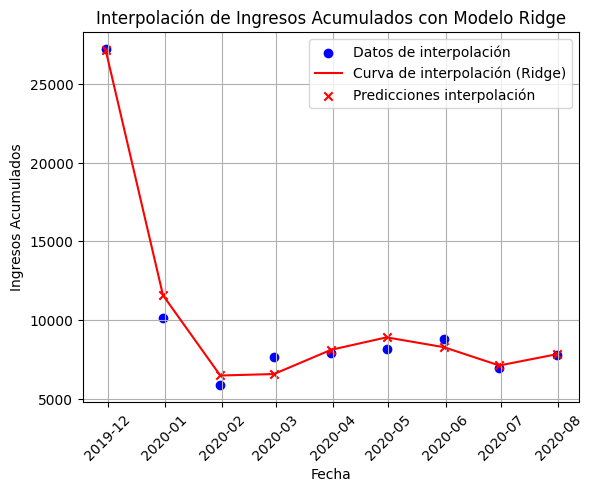

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge con alpha=0.0001 y entrenarlo
modelo = Ridge(alpha=0.0001)
modelo.fit(x_train_poly, y_train)

# Validación cruzada
scores = cross_val_score(modelo, x_train_poly, y_train, cv=5, scoring='r2')
print(f'R² promedio en validación cruzada: {np.mean(scores):.4f}')

# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = modelo.predict(x_train_poly)
y_test_pred = modelo.predict(x_test_poly)

# Cálculo de métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Coeficiente de Determinación (R²) - Entrenamiento: {r2_train:.4f}')
print(f'Coeficiente de Determinación (R²) - Prueba: {r2_test:.4f}')
print(f'Error Cuadrático Medio (MSE) - Entrenamiento: {mse_train:.4f}')
print(f'Error Cuadrático Medio (MSE) - Prueba: {mse_test:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas[:n_interpolacion], y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas[:n_interpolacion], modelo.predict(poly.transform(scaler.transform(x_interpolacion))), color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas[:n_interpolacion], modelo.predict(poly.transform(scaler.transform(x_interpolacion))), color='red', marker='x', label='Predicciones interpolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

R² promedio en validación cruzada: -4.8504
Coeficiente de Determinación (R²) - Entrenamiento: 0.9955
Coeficiente de Determinación (R²) - Prueba: 0.4270
Error Cuadrático Medio (MSE) - Entrenamiento: 243346.3802
Error Cuadrático Medio (MSE) - Prueba: 955910.7239


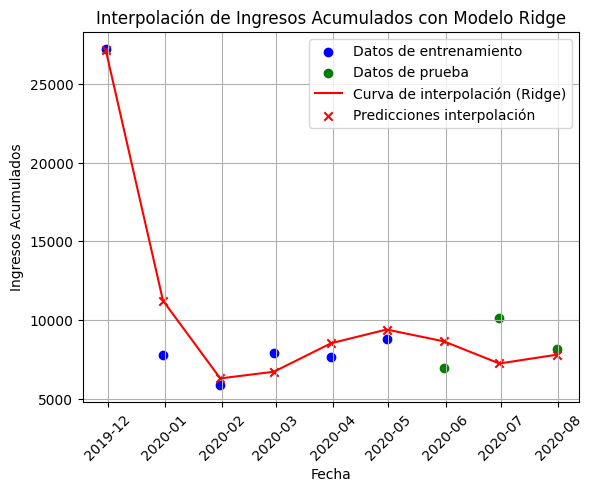

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]

# División en entrenamiento (75%) y prueba (25%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.25, random_state=42)

# Escalar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge con alpha=0.0001 y entrenarlo
modelo = Ridge(alpha=0.0001)
modelo.fit(x_train_poly, y_train)

# Validación cruzada
scores = cross_val_score(modelo, x_train_poly, y_train, cv=3, scoring='r2')
print(f'R² promedio en validación cruzada: {np.mean(scores):.4f}')

# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = modelo.predict(x_train_poly)
y_test_pred = modelo.predict(x_test_poly)

# Cálculo de métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Coeficiente de Determinación (R²) - Entrenamiento: {r2_train:.4f}')
print(f'Coeficiente de Determinación (R²) - Prueba: {r2_test:.4f}')
print(f'Error Cuadrático Medio (MSE) - Entrenamiento: {mse_train:.4f}')
print(f'Error Cuadrático Medio (MSE) - Prueba: {mse_test:.4f}')

# Graficar los datos originales de interpolación con distintos colores para entrenamiento y prueba
plt.scatter(fechas[:len(x_train)], y_train, label='Datos de entrenamiento', color='blue')
plt.scatter(fechas[len(x_train):n_interpolacion], y_test, label='Datos de prueba', color='green')
plt.plot(fechas[:n_interpolacion], modelo.predict(poly.transform(scaler.transform(x_interpolacion))), color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas[:n_interpolacion], modelo.predict(poly.transform(scaler.transform(x_interpolacion))), color='red', marker='x', label='Predicciones interpolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Usando un polinomio de grado 3 con Ridge alpha=0.2
Precisión del modelo en datos de prueba (R^2): -5.4941
Error Cuadrático Medio (MSE): 15935978.2773
Raíz del Error Cuadrático Medio (RMSE): 3991.9893


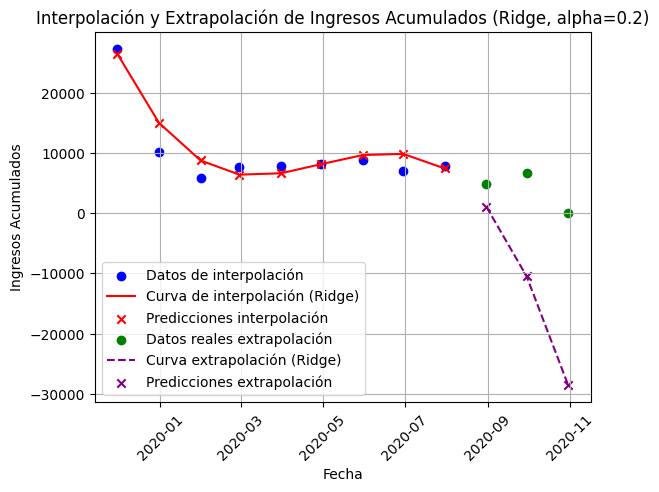

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Configurar la variable alpha que define el rango de grados del polinomio
# Alpha se puede ajustar en pasos más pequeños, por ejemplo: 0.1, 0.2, ..., 10
# Haremos un mapeo entre alpha y el grado del polinomio.
alpha = 0.2  # Parámetro de regularización (puedes probar con 0.1, 1.0, 10.0, etc.)

# Convertir alpha a un grado de polinomio (por ejemplo: alpha=0.1 se convertirá a grado 1, alpha=0.2 a grado 2, etc.)
grado_polinomio = 3  # Ajuste directo del grado del polinomio, puedes cambiarlo si lo deseas

print(f'Usando un polinomio de grado {grado_polinomio} con Ridge alpha={alpha}')

# Escalar los datos (opcional, puede mejorar la precisión en modelos polinómicos)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Transformar los datos para ajustar un modelo polinómico con el grado definido por alpha
poly = PolynomialFeatures(degree=grado_polinomio)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de Ridge Regression y entrenarlo
modelo_ridge = Ridge(alpha=alpha)  # Usamos Ridge en lugar de LinearRegression
modelo_ridge.fit(x_train_poly, y_train)

# Evaluar el modelo en los datos de prueba
score = modelo_ridge.score(x_test_poly, y_test)
print(f'Precisión del modelo en datos de prueba (R^2): {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(scaler.transform(x_interpolacion))
predicciones_interpolacion = modelo_ridge.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(scaler.transform(x_extrapolacion))
predicciones_extrapolacion = modelo_ridge.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (MSE) y el RMSE
mse = mean_squared_error(y_test, modelo_ridge.predict(x_test_poly))
rmse = np.sqrt(mse)
print(f'Error Cuadrático Medio (MSE): {mse:.4f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title(f'Interpolación y Extrapolación de Ingresos Acumulados (Ridge, alpha={alpha})')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


# **SEMI DEF**

### **Solo interpolacion**

R^2 en entrenamiento: 0.9988
R^2 en prueba: -0.3815


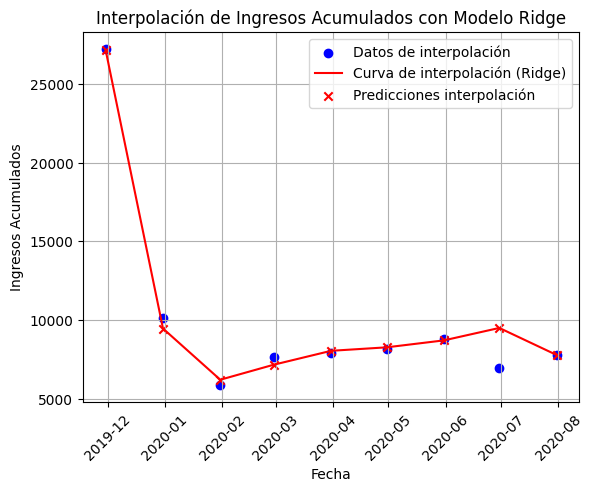

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Eliminar la columna '2020-11' si existe
datos_filtrados = cohorte_2019_12.drop(columns=['2020-11'], errors='ignore')

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=5)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0014)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en entrenamiento y prueba
r2_train = modelo.score(x_train_poly, y_train)
r2_test = modelo.score(x_test_poly, y_test)

print(f'R^2 en entrenamiento: {r2_train:.4f}')
print(f'R^2 en prueba: {r2_test:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

### **Todo modelo_Beta**

Precisión del modelo Ridge en datos de prueba: -2.4960


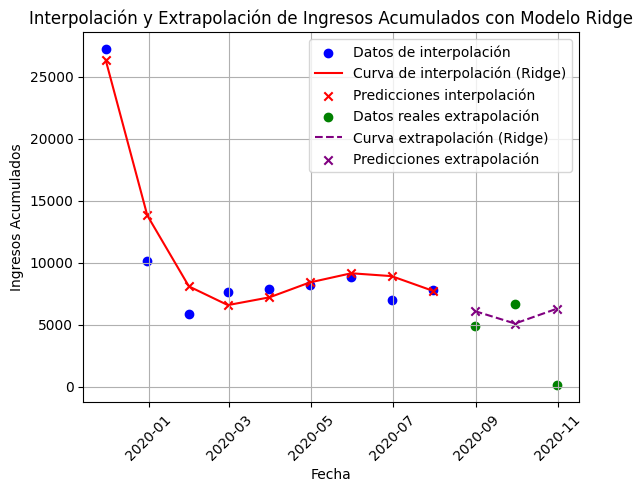

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge en lugar de LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


R^2 en entrenamiento: 0.9908
R^2 en prueba: -0.1696


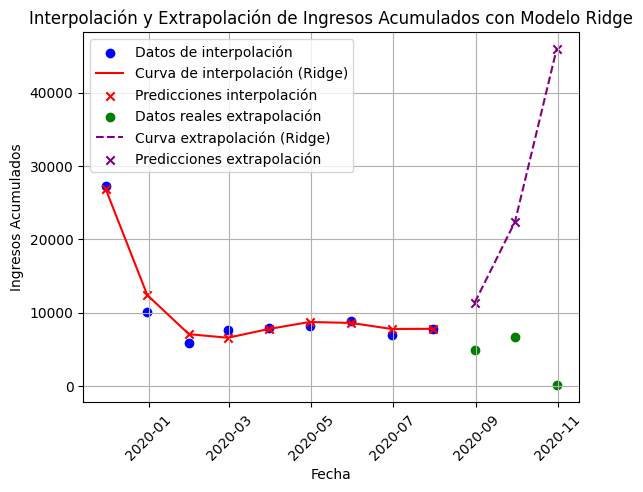

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Eliminar la columna '2020-11' si existe
datos_filtrados = cohorte_2019_12.drop(columns=['2020-11'], errors='ignore')

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Transformar los datos para ajustar un modelo polinómico de grado 5
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_extrapolacion_poly = poly.transform(x_extrapolacion)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.012)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en entrenamiento y prueba
r2_train = modelo.score(x_train_poly, y_train)
r2_test = modelo.score(x_test_poly, y_test)

print(f'R^2 en entrenamiento: {r2_train:.4f}')
print(f'R^2 en prueba: {r2_test:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


R^2 en entrenamiento: 0.9988
R^2 en prueba: -0.3815


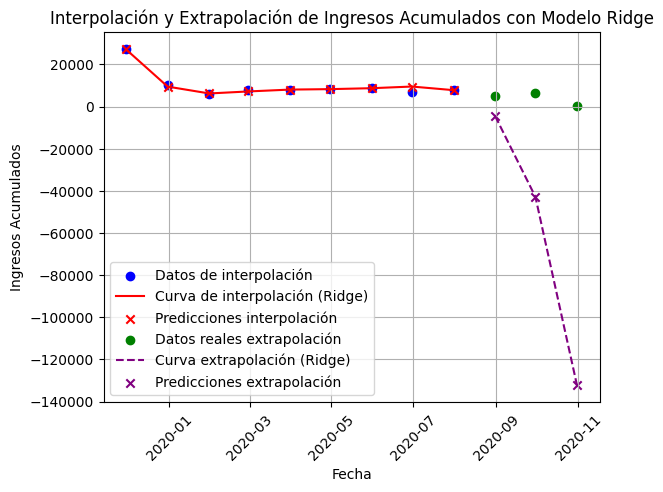

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Eliminar la columna '2020-11' si existe
datos_filtrados = cohorte_2019_12.drop(columns=['2020-11'], errors='ignore')

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Transformar los datos para ajustar un modelo polinómico de grado 5
poly = PolynomialFeatures(degree=5)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_extrapolacion_poly = poly.transform(x_extrapolacion)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0014)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo en entrenamiento y prueba
r2_train = modelo.score(x_train_poly, y_train)
r2_test = modelo.score(x_test_poly, y_test)

print(f'R^2 en entrenamiento: {r2_train:.4f}')
print(f'R^2 en prueba: {r2_test:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Prueba


📈 Correlación entre los últimos 3 puntos de interpolación y primeros 3 de extrapolación:
[[ 1.         -0.03210959]
 [-0.03210959  1.        ]]

📊 Evaluación del Modelo:
RMSE Interpolación: 641.917, RMSE Extrapolación: 263409.986
R² Interpolación: 0.988, R² Extrapolación: -0.682

🔍 Valores negativos en extrapolación:
[]

🔮 Predicción para Noviembre 2020: 36579201.56


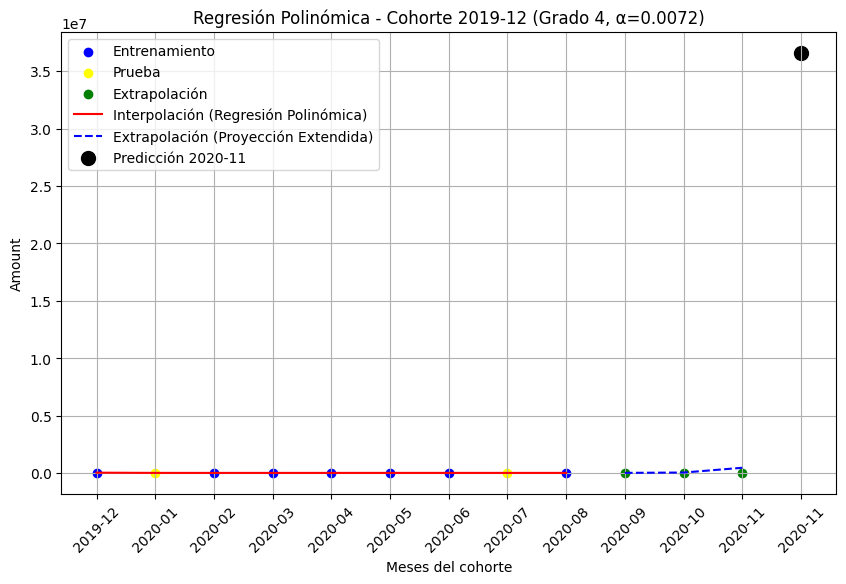

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Aplicar la transformación logarítmica en 'amount'
cohorte_2019_12_log = np.log1p(cohort_revenue.loc['2019-12'].dropna())

# 2️⃣ Convertir índices (Mes) a fechas tipo 'YYYY-MM'
X = pd.to_datetime(cohorte_2019_12_log.index.astype(str), format='%Y-%m')
X_numeric = np.array(range(len(X))).reshape(-1, 1)  # Convertir a índices numéricos para la regresión
y = np.array(cohorte_2019_12_log.values)  # Valores transformados

# 3️⃣ Separar 80% interpolación y 20% extrapolación
split_idx = int(len(X) * 0.80)
X_interp, X_extrap = X_numeric[:split_idx], X_numeric[split_idx:]
y_interp, y_extrap = y[:split_idx], y[split_idx:]

# 📍 Agregar el mes futuro "2020-11"
next_month_numeric = np.array([[X_numeric[-1][0] + 1]])  # El siguiente índice
X_extrap = np.vstack([X_extrap, next_month_numeric])  # Añadir el mes 2020-11 a la extrapolación

# 4️⃣ Dentro del 80% de interpolación, dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.20, random_state=42)


# 📈 Correlación entre los últimos puntos de interpolación y primeros de extrapolación
print("\n📈 Correlación entre los últimos 3 puntos de interpolación y primeros 3 de extrapolación:")
print(np.corrcoef(y_interp[-3:], y_extrap[:3]))

# 5️⃣ Ajustar modelo de regresión polinómica con Ridge para evitar sobreajuste
degree = 4  # Se puede probar con otros grados
alpha = 0.0072  # Regularización

poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_interp_poly = poly.transform(X_interp)
X_extrap_poly = poly.transform(X_extrap)

# 6️⃣ Entrenar modelo con Ridge
model = Ridge(alpha=alpha)
model.fit(X_train_poly, y_train)

# 7️⃣ Predicciones
y_interp_pred = model.predict(X_interp_poly)  # Predicciones en interpolación
y_extrap_pred = model.predict(X_extrap_poly)  # Predicciones en extrapolación

# Extraer predicción del mes 2020-11
y_future_pred = y_extrap_pred[-1]

# 8️⃣ Volver a la escala original (deshacer logaritmo)
y_interp_pred = np.expm1(y_interp_pred)
y_extrap_pred = np.expm1(y_extrap_pred)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)
y_extrap_orig = np.expm1(y_extrap)
y_future_pred_orig = np.expm1(y_future_pred)  # Valor predicho en escala original

# 9️⃣ Evaluación de modelo: RMSE y R²
rmse_interp = np.sqrt(mean_squared_error(y_interp_pred, np.expm1(y_interp)))
rmse_extrap = np.sqrt(mean_squared_error(y_extrap_pred[:-1], y_extrap_orig))  # Excluyendo mes futuro
r2_interp = r2_score(y_interp_pred, np.expm1(y_interp))
r2_extrap = r2_score(y_extrap_pred[:-1], y_extrap_orig)  # Excluyendo mes futuro

print(f"\n📊 Evaluación del Modelo:")
print(f"RMSE Interpolación: {rmse_interp:.3f}, RMSE Extrapolación: {rmse_extrap:.3f}")
print(f"R² Interpolación: {r2_interp:.3f}, R² Extrapolación: {r2_extrap:.3f}")

# 🔍 Ver si hay valores negativos en extrapolación (no deberían existir en Amount)
print("\n🔍 Valores negativos en extrapolación:")
print(y_extrap_pred[y_extrap_pred < 0])

# 🔮 Predicción para noviembre de 2020
print(f"\n🔮 Predicción para Noviembre 2020: {y_future_pred_orig:.2f}")

#  🔄 Convertir los valores numéricos de X a etiquetas de fecha
plt.figure(figsize=(10, 6))

# Datos originales transformados de vuelta
plt.scatter(X_train, y_train_orig, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test_orig, color='yellow', label='Prueba')
plt.scatter(X_extrap[:-1], y_extrap_orig, color='green', label='Extrapolación')

# Líneas de tendencia
plt.plot(X_interp, y_interp_pred, color='red', linestyle='-', label='Interpolación (Regresión Polinómica)')
plt.plot(X_extrap[:-1], y_extrap_pred[:-1], color='blue', linestyle='--', label='Extrapolación (Proyección Extendida)')

# 🔮 Resaltar predicción de noviembre 2020
plt.scatter(next_month_numeric, y_future_pred_orig, color='black', edgecolors='black', s=100, label='Predicción 2020-11')

# Configuración de la gráfica
plt.xticks(X_numeric.flatten().tolist() + [next_month_numeric[0][0]],
           X.strftime('%Y-%m').tolist() + ['2020-11'],
           rotation=45)
plt.xlabel("Meses del cohorte")
plt.ylabel("Amount")
plt.title(f"Regresión Polinómica - Cohorte 2019-12 (Grado {degree}, α={alpha})")
plt.legend()
plt.grid(True)
plt.show()

### **Error cuadratico medio del modelo en interpolacion (Prueba y Entrenamiento)**




Precisión del modelo Ridge en datos de prueba: -2.4960
Error Cuadrático Medio (MSE) - Entrenamiento: 1057559.1797
Coeficiente de Determinación (R²) - Entrenamiento: 0.9776
Error Cuadrático Medio (MSE) - Prueba: 8578945.4272
Coeficiente de Determinación (R²) - Prueba: -2.4960


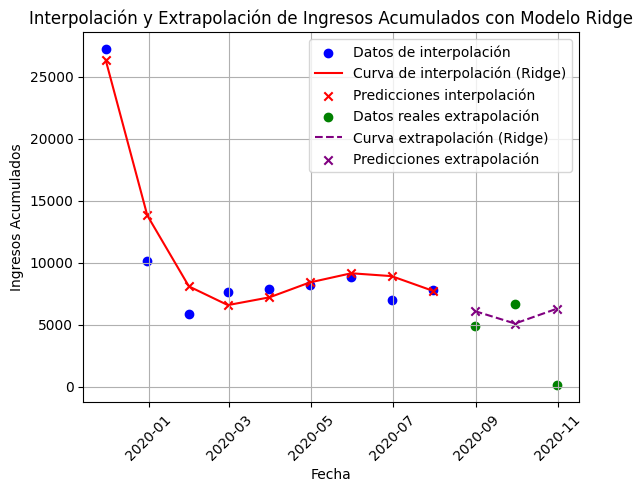

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge en lugar de LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = modelo.predict(x_train_poly)
y_test_pred = modelo.predict(x_test_poly)

# Cálculo de métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar resultados
print(f'Error Cuadrático Medio (MSE) - Entrenamiento: {mse_train:.4f}')
print(f'Coeficiente de Determinación (R²) - Entrenamiento: {r2_train:.4f}')
print(f'Error Cuadrático Medio (MSE) - Prueba: {mse_test:.4f}')
print(f'Coeficiente de Determinación (R²) - Prueba: {r2_test:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## ESTANDARIZACIÓN

Precisión del modelo Ridge en datos de prueba: 0.5583


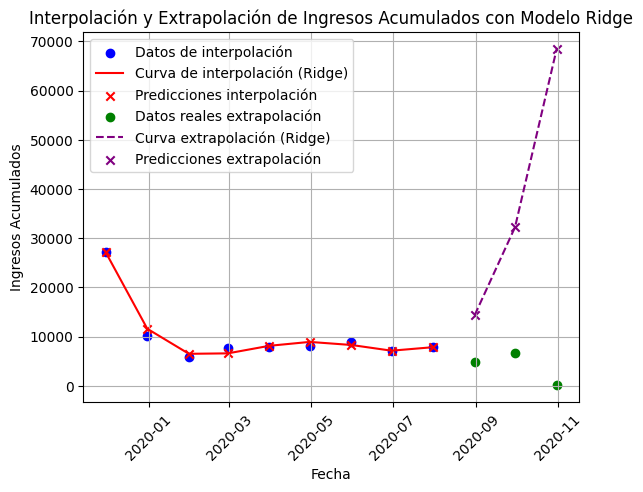

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge  # Importamos el modelo Ridge en lugar de LinearRegression
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0001)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

R^^2

R^2 para los datos de entrenamiento: 0.9928
Diferencia (delta) entre las predicciones y los valores reales en entrenamiento: [-708.09152572   70.48744982  -57.64123237 -679.45825821 -188.45890908
 1060.53326141  502.62921416]


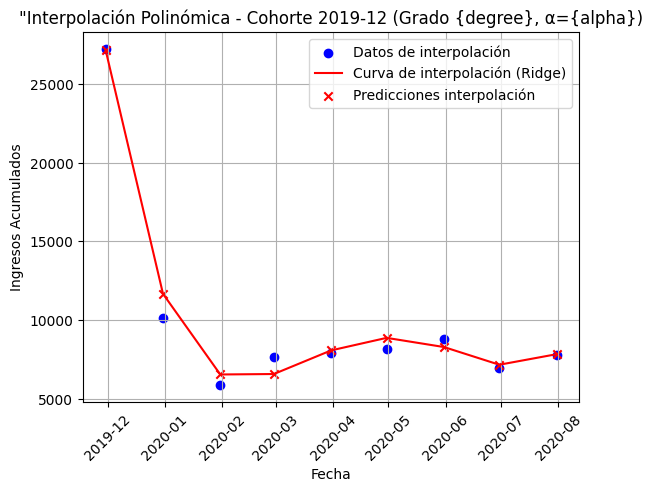

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score  # Importamos r2_score para calcular R^2

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.01)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = modelo.predict(x_train_poly)

# Calcular R^2 para los datos de entrenamiento
r2_train = r2_score(y_train, y_train_pred)
print(f'R^2 para los datos de entrenamiento: {r2_train:.4f}')

# Calcular la diferencia (delta) entre las predicciones y los valores reales en entrenamiento
delta = y_train - y_train_pred
print(f'Diferencia (delta) entre las predicciones y los valores reales en entrenamiento: {delta}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, modelo.predict(poly.transform(x_interpolacion_scaled)), color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, modelo.predict(poly.transform(x_interpolacion_scaled)), color='red', marker='x', label='Predicciones interpolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('"Interpolación Polinómica - Cohorte 2019-12 (Grado {degree}, α={alpha})')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## **Modelos Lasso y Ridge despues de estandarización**

Precisión del modelo Ridge en datos de prueba: 0.0230
Precisión del modelo Lasso en datos de prueba: 0.5571


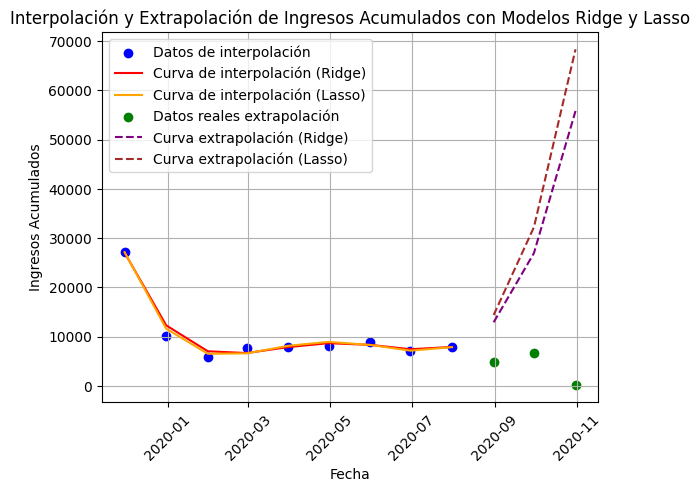

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso  # Importamos los modelos Ridge y Lasso
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear los modelos de regresión Ridge y Lasso
modelo_ridge = Ridge(alpha=0.1)
modelo_lasso = Lasso(alpha=0.1)

# Entrenar los modelos
modelo_ridge.fit(x_train_poly, y_train)
modelo_lasso.fit(x_train_poly, y_train)

# Evaluar los modelos
score_ridge = modelo_ridge.score(x_test_poly, y_test)
score_lasso = modelo_lasso.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score_ridge:.4f}')
print(f'Precisión del modelo Lasso en datos de prueba: {score_lasso:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion_ridge = modelo_ridge.predict(x_interpolacion_poly)
predicciones_interpolacion_lasso = modelo_lasso.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion_ridge = modelo_ridge.predict(x_extrapolacion_poly)
predicciones_extrapolacion_lasso = modelo_lasso.predict(x_extrapolacion_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_ridge, color='red', label='Curva de interpolación (Ridge)')
plt.plot(fechas_interpolacion, predicciones_interpolacion_lasso, color='orange', label='Curva de interpolación (Lasso)')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_ridge, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_lasso, color='brown', linestyle='--', label='Curva extrapolación (Lasso)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelos Ridge y Lasso')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo Ridge en datos de prueba: 0.3160
Precisión del modelo Lasso en datos de prueba: 0.5582


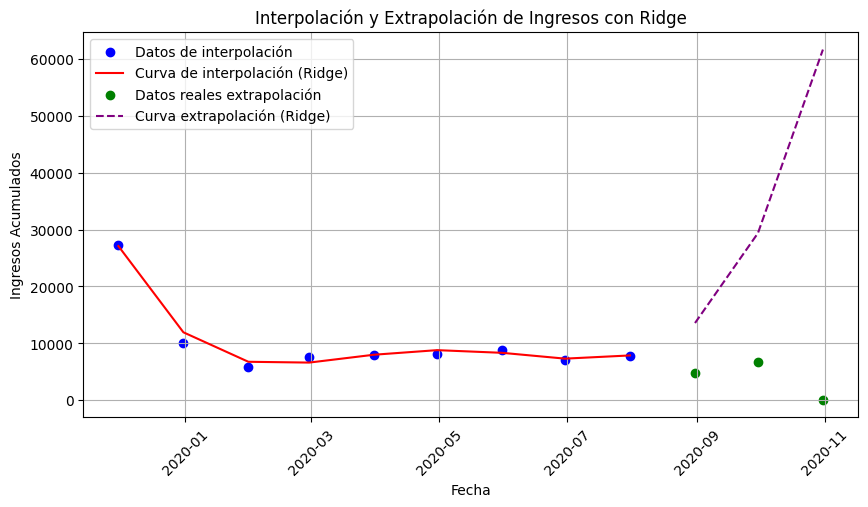

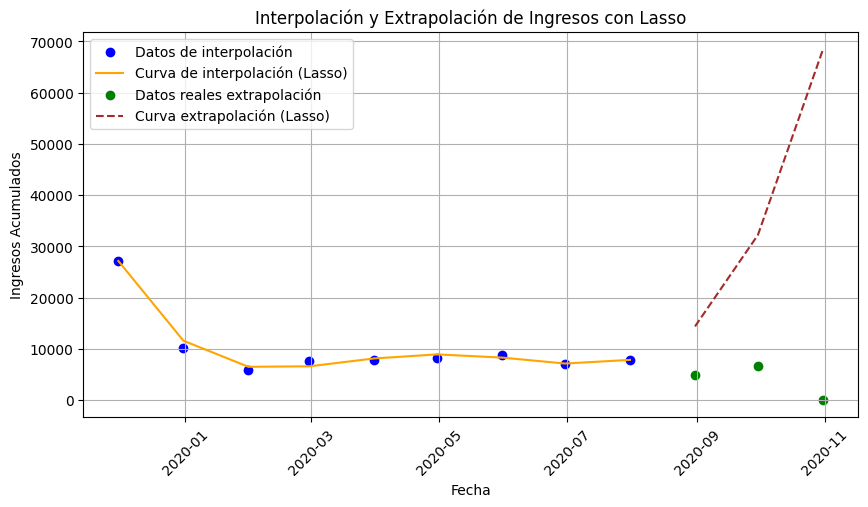

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso  # Importamos los modelos Ridge y Lasso
from sklearn.model_selection import train_test_split

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes
# Seleccionamos los datos de la cohorte 2019-12
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Estandarizar los datos
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_interpolacion_scaled = scaler.transform(x_interpolacion)
x_extrapolacion_scaled = scaler.transform(x_extrapolacion)

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.transform(x_test_scaled)

# Crear los modelos de regresión Ridge y Lasso
modelo_ridge = Ridge(alpha=0.042)
modelo_lasso = Lasso(alpha=0.042)

# Entrenar los modelos
modelo_ridge.fit(x_train_poly, y_train)
modelo_lasso.fit(x_train_poly, y_train)

# Evaluar los modelos
score_ridge = modelo_ridge.score(x_test_poly, y_test)
score_lasso = modelo_lasso.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score_ridge:.4f}')
print(f'Precisión del modelo Lasso en datos de prueba: {score_lasso:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion_scaled)
predicciones_interpolacion_ridge = modelo_ridge.predict(x_interpolacion_poly)
predicciones_interpolacion_lasso = modelo_lasso.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion_scaled)
predicciones_extrapolacion_ridge = modelo_ridge.predict(x_extrapolacion_poly)
predicciones_extrapolacion_lasso = modelo_lasso.predict(x_extrapolacion_poly)

# Graficar Ridge
plt.figure(figsize=(10,5))
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_ridge, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_ridge, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos con Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Graficar Lasso
plt.figure(figsize=(10,5))
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion_lasso, color='orange', label='Curva de interpolación (Lasso)')
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion_lasso, color='brown', linestyle='--', label='Curva extrapolación (Lasso)')
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos con Lasso')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## **Norm datos 2**

Precisión del modelo Ridge en datos de prueba: 0.5575
MSE en datos de interpolación: 505419.8050
RMSE en datos de interpolación: 710.9288
MSE en datos de extrapolación: 1800616916.8721
RMSE en datos de extrapolación: 42433.6767


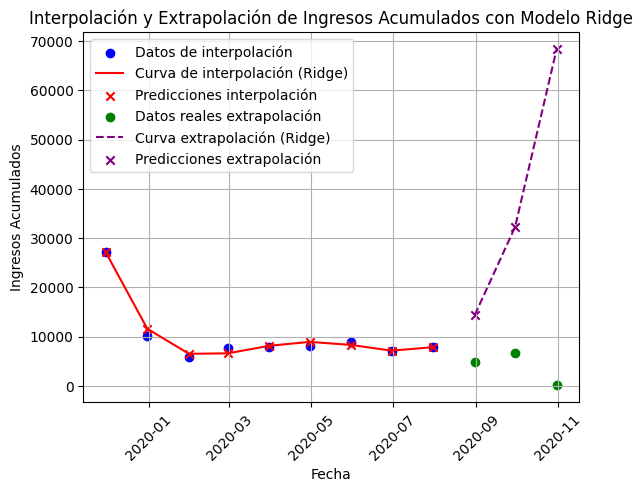

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # Importamos la función para calcular MSE y RMSE

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_interpolacion_poly = poly.transform(x_interpolacion)
x_extrapolacion_poly = poly.transform(x_extrapolacion)

# Aplicar estandarización con StandardScaler
scaler = StandardScaler()
x_train_poly = scaler.fit_transform(x_train_poly)
x_test_poly = scaler.transform(x_test_poly)
x_interpolacion_poly = scaler.transform(x_interpolacion_poly)
x_extrapolacion_poly = scaler.transform(x_extrapolacion_poly)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0000001)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


Precisión del modelo Ridge en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


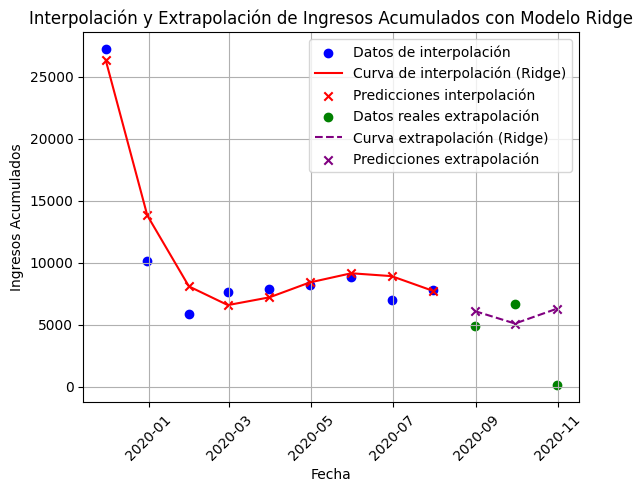

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # Importamos la función para calcular MSE y RMSE

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo Ridge en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


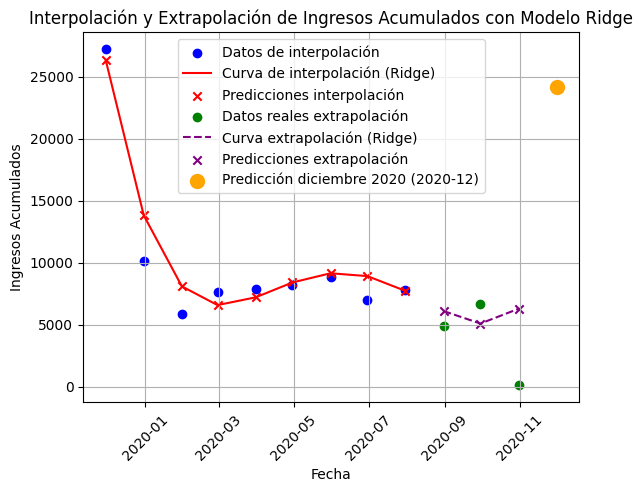

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: 0.2882
MSE en datos de interpolación: 666623.2596
RMSE en datos de interpolación: 816.4700
MSE en datos de extrapolación: 1305556061.4098
RMSE en datos de extrapolación: 36132.4793


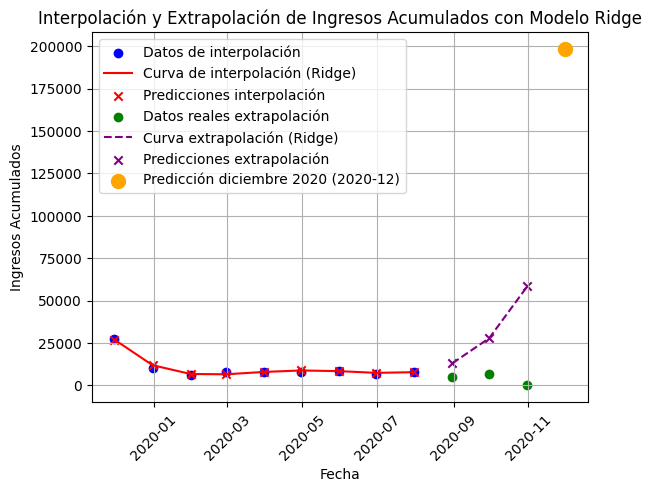

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Eliminar la columna '2020-11' si existe
datos_filtrados = cohorte_2019_12.drop(columns=['2020-11'], errors='ignore')

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.005)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.4960
MSE en datos de interpolación: 2728978.3458
RMSE en datos de interpolación: 1651.9620
MSE en datos de extrapolación: 14004765.5536
RMSE en datos de extrapolación: 3742.2942


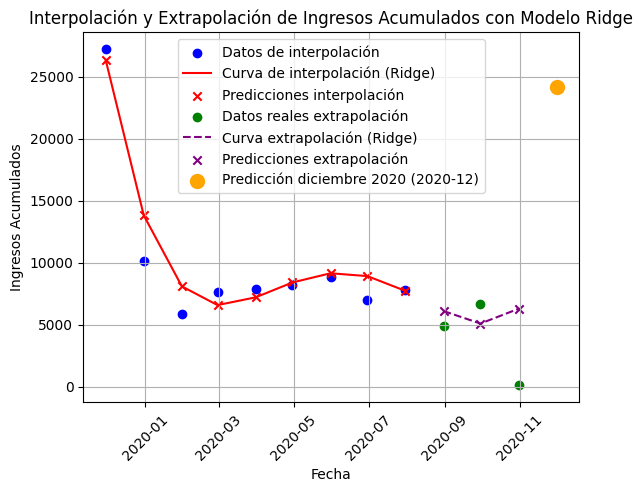

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = cohorte_2019_12.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-11', periods=len(datos_no_nulos -1), freq='M')

# División de los datos
n_total = len(datos_no_nulos -1)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.042)  # El parámetro alpha regula la regularización (valor por defecto 1.0)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [42]:
cohorte_2019_12 = cohort_revenue.loc['2019-12':'2020-10']

Precisión del modelo (R²) en datos de prueba: -1.8485
MSE en datos de interpolación: 946577.3032
RMSE en datos de interpolación: 972.9220
MSE en datos de extrapolación: 4780106.1344
RMSE en datos de extrapolación: 2186.3454


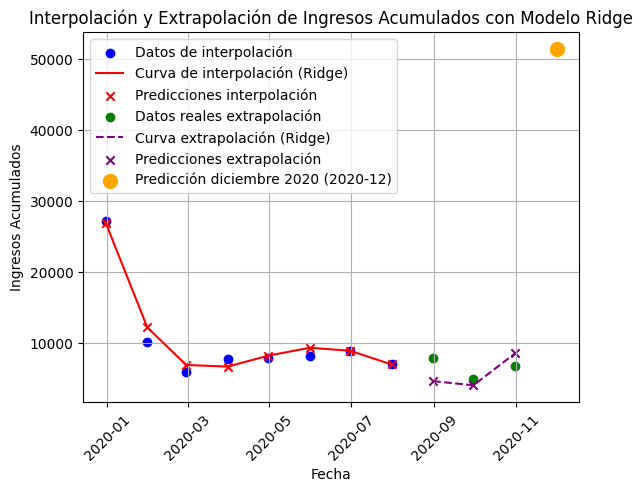

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Filtrar los datos entre 2019-12 y 2020-10
datos_filtrados = cohorte_2019_12.loc['2019-12':'2020-10']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-12', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.01)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Precisión del modelo (R²) en datos de prueba: -2.1227
MSE en datos de interpolación: 1036591.0476
RMSE en datos de interpolación: 1018.1312
MSE en datos de extrapolación: 6816137.3104
RMSE en datos de extrapolación: 2610.7733


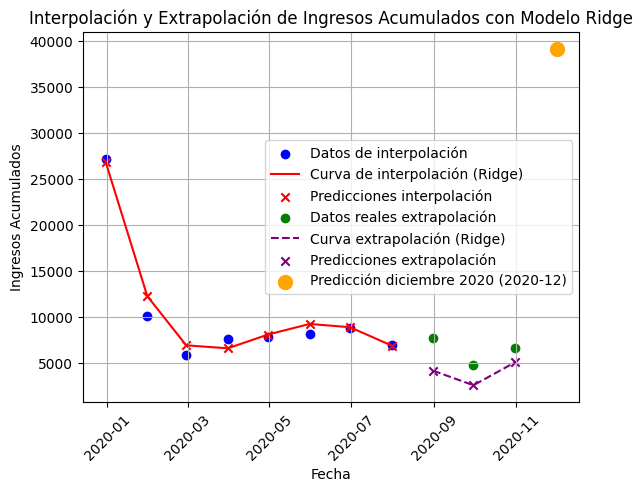

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Filtrar los datos entre 2019-12 y 2020-10
datos_filtrados = cohorte_2019_12.loc['2019-12':'2020-10']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-12', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0116)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Graficar la predicción de diciembre 2020
plt.scatter(fecha_objetivo, prediccion_diciembre_2020, color='orange', s=100, zorder=5, label=f'Predicción diciembre 2020 (2020-12)')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# TEST HOY

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Supongamos que ahora tienes los ingresos acumulados por cohorte y mes en `cohort_revenue_acumulado`
# Seleccionamos los datos de la cohorte 2019-12 (como ejemplo)
cohorte_2019_12 = cohort_revenue.loc['2019-12']

# Filtrar los datos entre 2019-12 y 2020-10
datos_filtrados = cohorte_2019_12.loc['2019-12':'2020-10']

# Crear un DataFrame con los valores no nulos
datos_no_nulos = datos_filtrados.dropna()
x_no_nulos = np.array(range(len(datos_no_nulos))).reshape(-1, 1)
y_no_nulos = datos_no_nulos.values

# Generar etiquetas de fechas para el eje x
fechas = pd.date_range(start='2019-12', periods=len(datos_no_nulos), freq='M')

# División de los datos
n_total = len(datos_no_nulos)
n_interpolacion = int(n_total * 0.8)
n_extrapolacion = n_total - n_interpolacion

# Datos para interpolación (80%)
datos_interpolacion = datos_no_nulos.iloc[:n_interpolacion]
x_interpolacion = x_no_nulos[:n_interpolacion]
y_interpolacion = y_no_nulos[:n_interpolacion]
fechas_interpolacion = fechas[:n_interpolacion]

# División en entrenamiento (80%) y prueba (20%)
x_train, x_test, y_train, y_test = train_test_split(x_interpolacion, y_interpolacion, test_size=0.2, random_state=42)

# Datos para extrapolación (20%)
datos_extrapolacion = datos_no_nulos.iloc[n_interpolacion:]
x_extrapolacion = x_no_nulos[n_interpolacion:]
y_extrapolacion = y_no_nulos[n_interpolacion:]
fechas_extrapolacion = fechas[n_interpolacion:]

# Transformar los datos para ajustar un modelo polinómico de grado 4
poly = PolynomialFeatures(degree=4)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Crear el modelo de regresión Ridge y entrenarlo
modelo = Ridge(alpha=0.0116)
modelo.fit(x_train_poly, y_train)

# Evaluar el modelo
score = modelo.score(x_test_poly, y_test)
print(f'Precisión del modelo (R²) en datos de prueba: {score:.4f}')

# Predicciones en el conjunto completo de interpolación
x_interpolacion_poly = poly.transform(x_interpolacion)
predicciones_interpolacion = modelo.predict(x_interpolacion_poly)

# Predicciones para extrapolación
x_extrapolacion_poly = poly.transform(x_extrapolacion)
predicciones_extrapolacion = modelo.predict(x_extrapolacion_poly)

# Calcular el Error Cuadrático Medio (RMSE) y el Error Medio Cuadrático (MSE)
mse_interpolacion = mean_squared_error(y_interpolacion, predicciones_interpolacion)
rmse_interpolacion = np.sqrt(mse_interpolacion)

mse_extrapolacion = mean_squared_error(y_extrapolacion, predicciones_extrapolacion)
rmse_extrapolacion = np.sqrt(mse_extrapolacion)

# Mostrar los resultados
print(f'MSE en datos de interpolación: {mse_interpolacion:.4f}')
print(f'RMSE en datos de interpolación: {rmse_interpolacion:.4f}')
print(f'MSE en datos de extrapolación: {mse_extrapolacion:.4f}')
print(f'RMSE en datos de extrapolación: {rmse_extrapolacion:.4f}')

# --- Predicción para diciembre de 2020 ---
fecha_objetivo = pd.Timestamp('2020-12-01')

# Calcular el índice correspondiente a diciembre de 2020
indice_objetivo = len(datos_no_nulos) + (fecha_objetivo - fechas[-1]).days // 30

# Transformar el índice con el polinomio
indice_objetivo_poly = poly.transform([[indice_objetivo]])

# Realizar la predicción para diciembre de 2020
prediccion_diciembre_2020 = modelo.predict(indice_objetivo_poly)

# Graficar los datos originales de interpolación
plt.scatter(fechas_interpolacion, y_interpolacion, label='Datos de interpolación', color='blue')
plt.plot(fechas_interpolacion, predicciones_interpolacion, color='red', label='Curva de interpolación (Ridge)')
plt.scatter(fechas_interpolacion, predicciones_interpolacion, color='red', marker='x', label='Predicciones interpolación')

# Graficar los datos de extrapolación
plt.scatter(fechas_extrapolacion, y_extrapolacion, label='Datos reales extrapolación', color='green')
plt.plot(fechas_extrapolacion, predicciones_extrapolacion, color='purple', linestyle='--', label='Curva extrapolación (Ridge)')
plt.scatter(fechas_extrapolacion, predicciones_extrapolacion, color='purple', marker='x', label='Predicciones extrapolación')

# Configuración del gráfico
plt.xlabel('Fecha')
plt.ylabel('Ingresos Acumulados')
plt.title('Interpolación y Extrapolación de Ingresos Acumulados con Modelo Ridge')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

KeyError: '2019-12'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mes      2019-12  2020-01  2020-02  2020-03  2020-04  2020-05  2020-06  \
Cohorte                                                                  
2019-12  27197.0  10123.0   5881.0   7650.0   7900.0   8175.0   8805.0   

Mes      2020-07  2020-08  2020-09  2020-10  2020-11  
Cohorte                                               
2019-12   6990.0   7790.0   4860.0   6655.0    100.0  


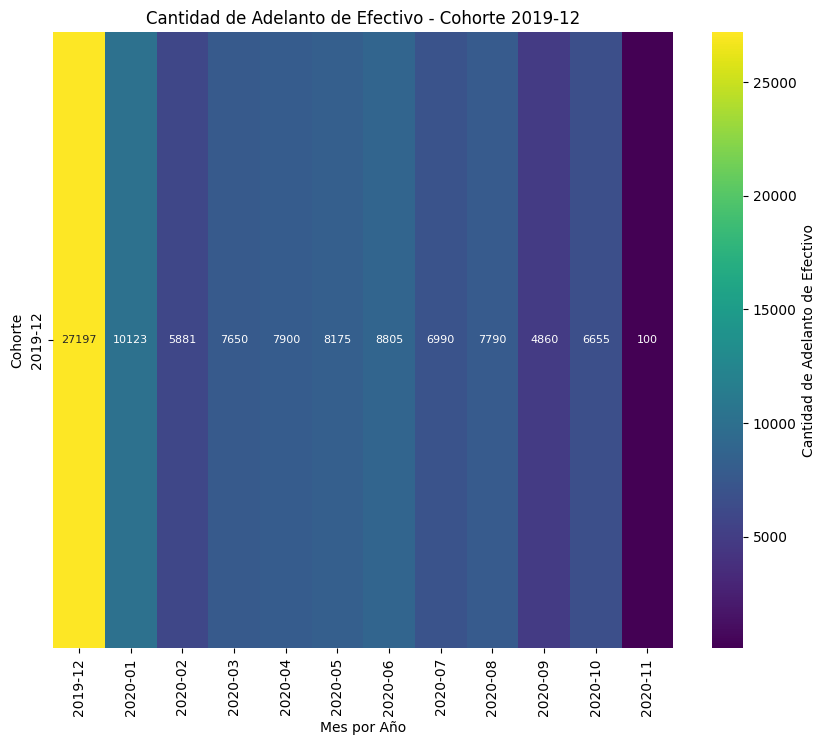

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Montar Google Drive y cargar los datos
from google.colab import drive
drive.mount('/content/drive')

# Cargar datasets
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')

# Crear copias de los datos
cr = credit_requests.copy()
fs = fees.copy()

# Filtrar columnas relevantes
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Rellenar valores nulos y eliminar la columna 'deleted_account_id'
cr.fillna({'user_id': cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir fechas
cr['created_at'] = pd.to_datetime(cr['created_at']).dt.tz_localize(None)

# Crear columna de mes y cohorte
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Filtrar la cohorte de diciembre 2019
cr_filtrado = cr[(cr['Cohorte'] == '2019-12')]

# Calcular el total de adelantos de efectivo por mes dentro de la cohorte
cohort_revenue = cr_filtrado.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()

# Crear tabla pivote
cohort_revenue_pivot = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

# Mostrar datos filtrados
print(cohort_revenue_pivot)

# Graficar la cantidad de adelanto de efectivo por cohorte y mes
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo - Cohorte 2019-12')

sns.heatmap(
    data=cohort_revenue_pivot,
    annot=True,
    fmt='.0f',
    cmap='viridis',
    annot_kws={'size': 8},
    cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'}
)

plt.xlabel('Mes por Año')
plt.ylabel('Cohorte')
plt.show()

Train RMSE: 448.64, Train R²: 0.97
Test RMSE: 2545.29, Test R²: 0.94


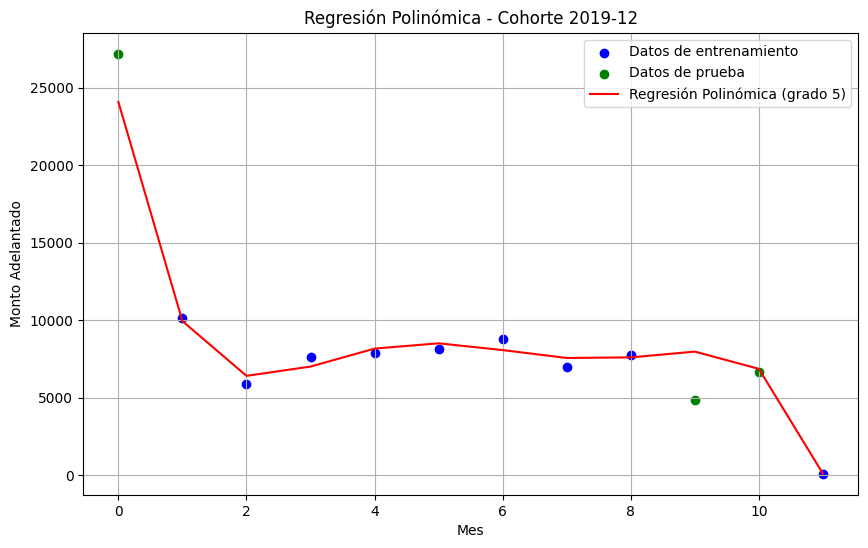

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datasets
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')

# Crear copias de los datos
cr = credit_requests.copy()
fs = fees.copy()

# Filtrar columnas relevantes
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Rellenar valores nulos y eliminar la columna 'deleted_account_id'
cr.fillna({'user_id': cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir fechas
cr['created_at'] = pd.to_datetime(cr['created_at']).dt.tz_localize(None)

# Crear columna de mes y cohorte
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Filtrar la cohorte de diciembre 2019
cr_filtrado = cr[(cr['Cohorte'] == '2019-12')]

# Calcular el total de adelantos de efectivo por mes dentro de la cohorte
cohort_revenue = cr_filtrado.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()

# Crear tabla pivote
cohort_revenue_pivot = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')
#######################
# CARGA DE DATOS

# Definir X y y (Asegúrate de que cohort_revenue_pivot esté definido)
X = np.arange(len(cohort_revenue_pivot.columns)).reshape(-1, 1)
y = cohort_revenue_pivot.iloc[0].fillna(0).values

# Transformación polinómica
degree = 5
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# Modelo de regresión Ridge
model = Ridge(alpha=0.001)
model.fit(X_train_poly, y_train)

# Predicciones
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Evaluación del modelo
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train RMSE: {rmse_train:.2f}, Train R²: {r2_train:.2f}')
print(f'Test RMSE: {rmse_test:.2f}, Test R²: {r2_test:.2f}')

# Graficar la regresión polinómica
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.scatter(X_test, y_test, color='green', label='Datos de prueba')
X_sorted = np.sort(X, axis=0)
X_poly_sorted = poly.transform(X_sorted)
plt.plot(X_sorted, model.predict(X_poly_sorted), color='red', linestyle='-', label=f'Regresión Polinómica (grado {degree})')
plt.xlabel('Mes')
plt.ylabel('Monto Adelantado')
plt.title('Regresión Polinómica - Cohorte 2019-12')
plt.legend()
plt.grid(True)
plt.show()

Train RMSE: 756.00, Train R²: 0.92
Test RMSE: 7202.30, Test R²: 0.49


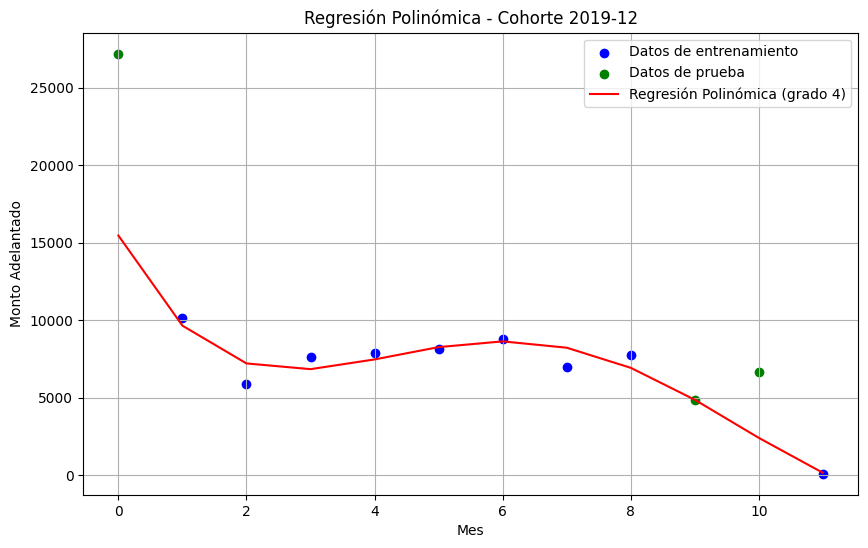

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Suponiendo que ya has cargado los datos correctamente

# Definir X y y (Asegúrate de que cohort_revenue_pivot esté definido)
X = np.arange(len(cohort_revenue_pivot.columns)).reshape(-1, 1)
y = cohort_revenue_pivot.iloc[0].fillna(0).values

# Transformación polinómica
degree = 4
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# Modelo de regresión Ridge
model = Ridge(alpha=0.0001)
model.fit(X_train_poly, y_train)

# Predicciones
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Evaluación del modelo
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train RMSE: {rmse_train:.2f}, Train R²: {r2_train:.2f}')
print(f'Test RMSE: {rmse_test:.2f}, Test R²: {r2_test:.2f}')

# Graficar la regresión polinómica
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.scatter(X_test, y_test, color='green', label='Datos de prueba')
X_sorted = np.sort(X, axis=0)
X_poly_sorted = poly.transform(X_sorted)
plt.plot(X_sorted, model.predict(X_poly_sorted), color='red', linestyle='-', label=f'Regresión Polinómica (grado {degree})')
plt.xlabel('Mes')
plt.ylabel('Monto Adelantado')
plt.title('Regresión Polinómica - Cohorte 2019-12')
plt.legend()
plt.grid(True)
plt.show()

Interpolación - Datos de entrenamiento: RMSE = 473.77, R² = 1.00
Interpolación - Datos de prueba: RMSE = 1121.07, R² = 0.49
Extrapolación: RMSE = 6458.49, R² = -4.45


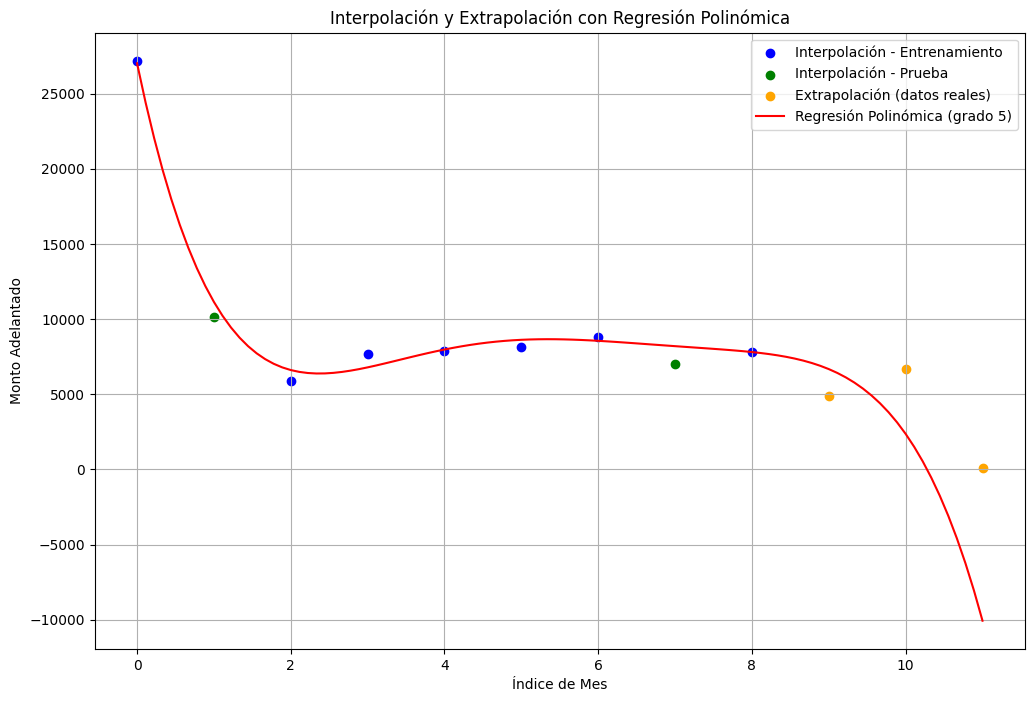

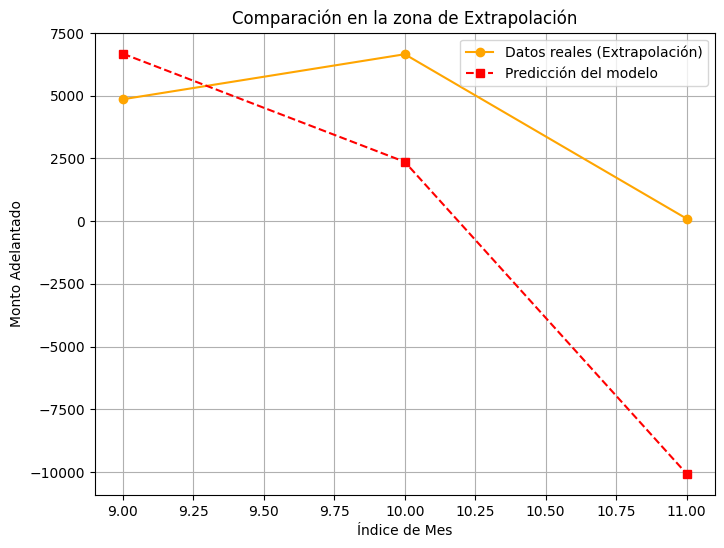

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datasets
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')

# Crear copias de los datos
cr = credit_requests.copy()
fs = fees.copy()

# Filtrar columnas relevantes
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Rellenar valores nulos y eliminar la columna 'deleted_account_id'
cr.fillna({'user_id': cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir la columna de fechas
cr['created_at'] = pd.to_datetime(cr['created_at']).dt.tz_localize(None)

# Crear columnas de Mes y Cohorte
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Filtrar la cohorte de diciembre de 2019
cr_filtrado = cr[cr['Cohorte'] == '2019-12']

# Calcular el total de adelantos de efectivo por mes dentro de la cohorte
cohort_revenue = cr_filtrado.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()

# Crear tabla pivote (filas = cohorte, columnas = meses)
cohort_revenue_pivot = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

# DEFINIR X e y (utilizamos la primera fila, correspondiente a la cohorte 2019-12)
X = np.arange(len(cohort_revenue_pivot.columns)).reshape(-1, 1)
y = cohort_revenue_pivot.iloc[0].fillna(0).values

# %% Separar datos en Interpolación (80% inicial) y Extrapolación (20% final)
n_total = len(X)
n_interp = int(0.8 * n_total)  # 80% para interpolación
# Los primeros n_interp puntos serán para interpolación
X_interp = X[:n_interp]
y_interp = y[:n_interp]
# Los puntos restantes (último 20%) se usarán para extrapolación
X_extrap = X[n_interp:]
y_extrap = y[n_interp:]

# %% Dividir los datos de interpolación en entrenamiento (80%) y prueba (20%)
# Nota: se realiza una división aleatoria dentro del rango de interpolación.
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, random_state=42)

# %% Transformación polinómica
degree = 5
poly = PolynomialFeatures(degree)
# Ajustamos la transformación con X_train y transformamos los conjuntos
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# %% Entrenar el modelo de regresión Ridge
model = Ridge(alpha=0.0042)
model.fit(X_train_poly, y_train)

# %% Predicciones para interpolación
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calcular métricas para el conjunto de interpolación (entrenamiento y prueba)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Interpolación - Datos de entrenamiento: RMSE = {rmse_train:.2f}, R² = {r2_train:.2f}')
print(f'Interpolación - Datos de prueba: RMSE = {rmse_test:.2f}, R² = {r2_test:.2f}')

# %% Predicción en la zona de extrapolación
X_extrap_poly = poly.transform(X_extrap)
y_extrap_pred = model.predict(X_extrap_poly)

# Métricas para extrapolación
rmse_extrap = np.sqrt(mean_squared_error(y_extrap, y_extrap_pred))
r2_extrap = r2_score(y_extrap, y_extrap_pred)
print(f'Extrapolación: RMSE = {rmse_extrap:.2f}, R² = {r2_extrap:.2f}')

# %% Graficar los resultados
plt.figure(figsize=(12,8))

# Graficamos los datos de interpolación
plt.scatter(X_train, y_train, color='blue', label='Interpolación - Entrenamiento')
plt.scatter(X_test, y_test, color='green', label='Interpolación - Prueba')

# Graficamos los datos de extrapolación
plt.scatter(X_extrap, y_extrap, color='orange', label='Extrapolación (datos reales)')

# Para mostrar la curva ajustada, generamos una grilla de valores en todo el rango de X
X_curve = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_curve_poly = poly.transform(X_curve)
y_curve = model.predict(X_curve_poly)
plt.plot(X_curve, y_curve, color='red', linestyle='-', label=f'Regresión Polinómica (grado {degree})')

plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Interpolación y Extrapolación con Regresión Polinómica')
plt.legend()
plt.grid(True)
plt.show()

# Opcional: Graficar el contraste entre datos reales y predichos en extrapolación
plt.figure(figsize=(8,6))
plt.plot(X_extrap, y_extrap, 'o-', color='orange', label='Datos reales (Extrapolación)')
plt.plot(X_extrap, y_extrap_pred, 's--', color='red', label='Predicción del modelo')
plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Comparación en la zona de Extrapolación')
plt.legend()
plt.grid(True)
plt.show()

Interpolación - Datos de entrenamiento: RMSE = 480.46, R² = 1.00
Interpolación - Datos de prueba: RMSE = 1123.36, R² = 0.49
Extrapolación: RMSE = 4525.13, R² = -1.68


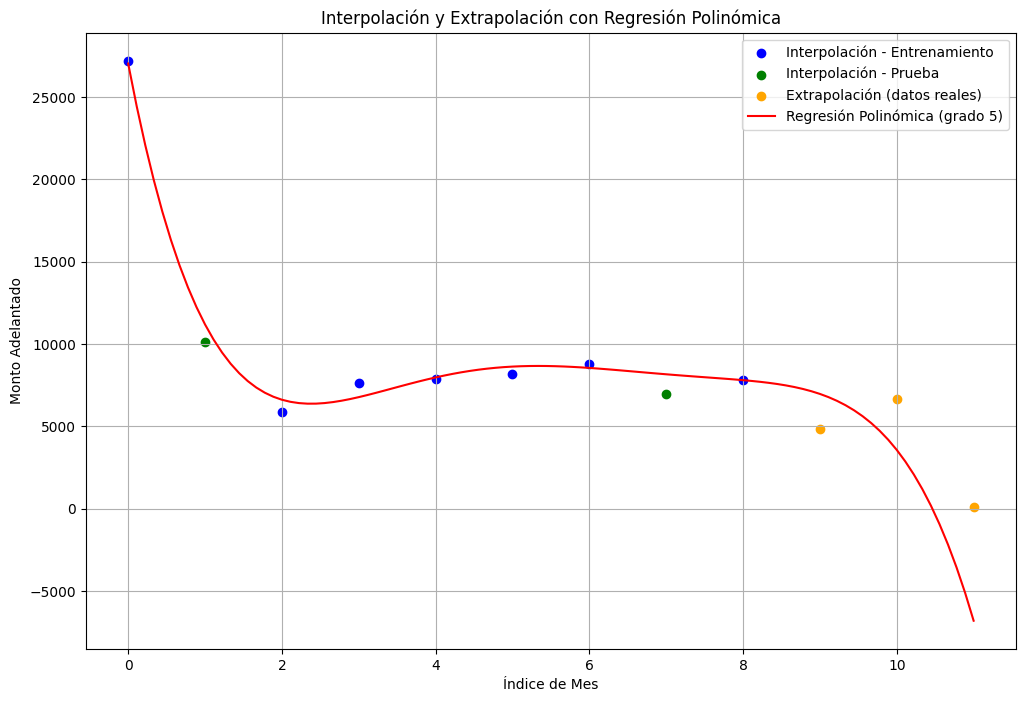

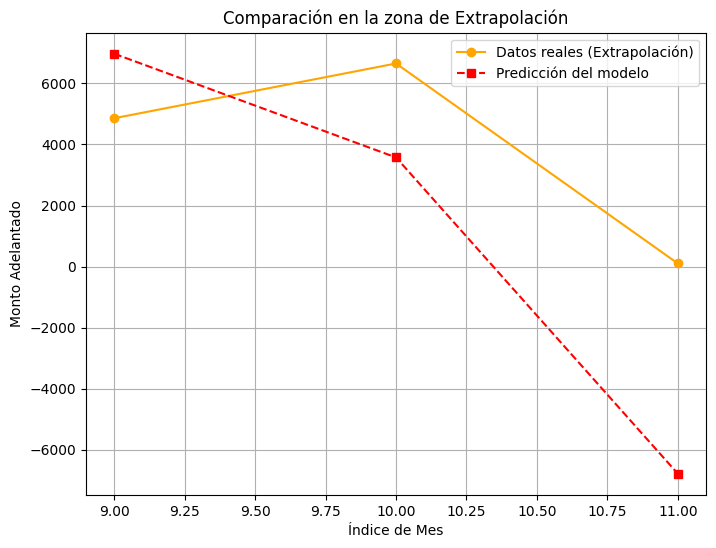

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datasets
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')

# Crear copias de los datos
cr = credit_requests.copy()
fs = fees.copy()

# Filtrar columnas relevantes
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Rellenar valores nulos y eliminar la columna 'deleted_account_id'
cr.fillna({'user_id': cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir la columna de fechas
cr['created_at'] = pd.to_datetime(cr['created_at']).dt.tz_localize(None)

# Crear columnas de Mes y Cohorte
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Filtrar la cohorte de diciembre de 2019
cr_filtrado = cr[cr['Cohorte'] == '2019-12']

# Calcular el total de adelantos de efectivo por mes dentro de la cohorte
cohort_revenue = cr_filtrado.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()

# Eliminar la columna '2020-11' si aún existe
if '2020-11' in cohort_revenue.columns:
    cohort_revenue = cohort_revenue.drop(columns=['2020-11'])

# Crear tabla pivote (filas = cohorte, columnas = meses)
cohort_revenue_pivot = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

# DEFINIR X e y (utilizamos la primera fila, correspondiente a la cohorte 2019-12)
X = np.arange(len(cohort_revenue_pivot.columns)).reshape(-1, 1)
y = cohort_revenue_pivot.iloc[0].fillna(0).values

# %% Separar datos en Interpolación (80% inicial) y Extrapolación (20% final)
n_total = len(X)
n_interp = int(0.8 * n_total)  # 80% para interpolación
# Los primeros n_interp puntos serán para interpolación
X_interp = X[:n_interp]
y_interp = y[:n_interp]
# Los puntos restantes (último 20%) se usarán para extrapolación
X_extrap = X[n_interp:]
y_extrap = y[n_interp:]

# %% Dividir los datos de interpolación en entrenamiento (80%) y prueba (20%)
# Nota: se realiza una división aleatoria dentro del rango de interpolación.
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, random_state=42)

# %% Transformación polinómica
degree = 5
poly = PolynomialFeatures(degree)
# Ajustamos la transformación con X_train y transformamos los conjuntos
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# %% Entrenar el modelo de regresión Ridge
model = Ridge(alpha=0.0043)
model.fit(X_train_poly, y_train)

# %% Predicciones para interpolación
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calcular métricas para el conjunto de interpolación (entrenamiento y prueba)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Interpolación - Datos de entrenamiento: RMSE = {rmse_train:.2f}, R² = {r2_train:.2f}')
print(f'Interpolación - Datos de prueba: RMSE = {rmse_test:.2f}, R² = {r2_test:.2f}')

# %% Predicción en la zona de extrapolación
X_extrap_poly = poly.transform(X_extrap)
y_extrap_pred = model.predict(X_extrap_poly)

# Métricas para extrapolación
rmse_extrap = np.sqrt(mean_squared_error(y_extrap, y_extrap_pred))
r2_extrap = r2_score(y_extrap, y_extrap_pred)
print(f'Extrapolación: RMSE = {rmse_extrap:.2f}, R² = {r2_extrap:.2f}')

# %% Graficar los resultados
plt.figure(figsize=(12,8))

# Graficamos los datos de interpolación
plt.scatter(X_train, y_train, color='blue', label='Interpolación - Entrenamiento')
plt.scatter(X_test, y_test, color='green', label='Interpolación - Prueba')

# Graficamos los datos de extrapolación
plt.scatter(X_extrap, y_extrap, color='orange', label='Extrapolación (datos reales)')

# Para mostrar la curva ajustada, generamos una grilla de valores en todo el rango de X
X_curve = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_curve_poly = poly.transform(X_curve)
y_curve = model.predict(X_curve_poly)
plt.plot(X_curve, y_curve, color='red', linestyle='-', label=f'Regresión Polinómica (grado {degree})')

plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Interpolación y Extrapolación con Regresión Polinómica')
plt.legend()
plt.grid(True)
plt.show()

# Opcional: Graficar el contraste entre datos reales y predichos en extrapolación
plt.figure(figsize=(8,6))
plt.plot(X_extrap, y_extrap, 'o-', color='orange', label='Datos reales (Extrapolación)')
plt.plot(X_extrap, y_extrap_pred, 's--', color='red', label='Predicción del modelo')
plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Comparación en la zona de Extrapolación')
plt.legend()
plt.grid(True)
plt.show()

Interpolación - Datos de entrenamiento: RMSE = 584.27, R² = 0.99
Interpolación - Datos de prueba: RMSE = 1125.29, R² = 0.48
Extrapolación: RMSE = 40506.31, R² = -213.49


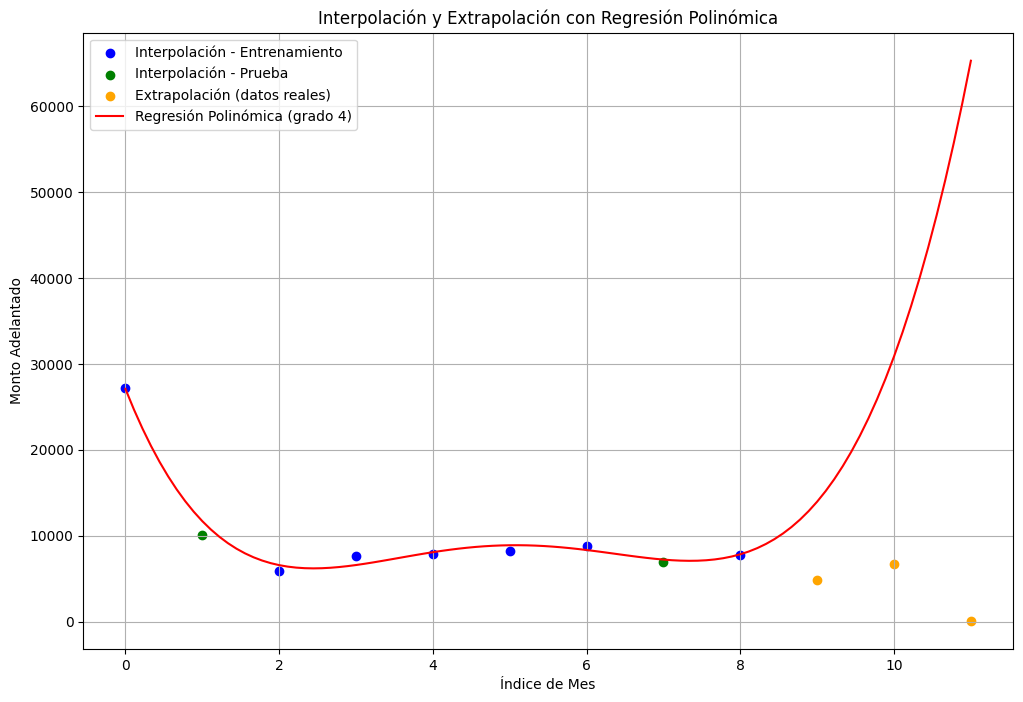

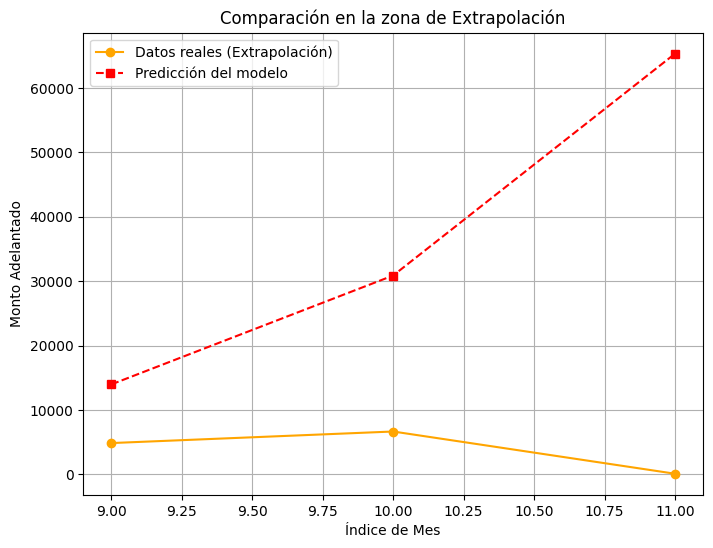

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargar datasets
credit_requests = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - cash request - data analyst.csv')
fees = pd.read_csv('/content/drive/MyDrive/ESPECIALITZACIÓ/IA/PROYECTOS/Proyecto2/Elementos/extract - fees - data analyst - .csv')

# Crear copias de los datos
cr = credit_requests.copy()
fs = fees.copy()

# Filtrar columnas relevantes
cr = cr[['amount', 'created_at', 'user_id', 'deleted_account_id', 'transfer_type']]

# Rellenar valores nulos y eliminar la columna 'deleted_account_id'
cr.fillna({'user_id': cr['deleted_account_id']}, inplace=True)
cr.drop(columns=['deleted_account_id'], inplace=True)

# Convertir la columna de fechas
cr['created_at'] = pd.to_datetime(cr['created_at']).dt.tz_localize(None)

# Crear columnas de Mes y Cohorte
cr['Mes'] = cr['created_at'].dt.to_period('M')
cr['Cohorte'] = cr.groupby('user_id')['created_at'].transform('min').dt.to_period('M')

# Filtrar la cohorte de diciembre de 2019
cr_filtrado = cr[cr['Cohorte'] == '2019-12']

# Calcular el total de adelantos de efectivo por mes dentro de la cohorte
cohort_revenue = cr_filtrado.groupby(['Cohorte', 'Mes'])['amount'].sum().reset_index()

# Crear tabla pivote (filas = cohorte, columnas = meses)
cohort_revenue_pivot = cohort_revenue.pivot(index='Cohorte', columns='Mes', values='amount')

# DEFINIR X e y (utilizamos la primera fila, correspondiente a la cohorte 2019-12)
X = np.arange(len(cohort_revenue_pivot.columns)).reshape(-1, 1)
y = cohort_revenue_pivot.iloc[0].fillna(0).values

# %% Separar datos en Interpolación (80% inicial) y Extrapolación (20% final)
n_total = len(X)
n_interp = int(0.8 * n_total)  # 80% para interpolación
# Los primeros n_interp puntos serán para interpolación
X_interp = X[:n_interp]
y_interp = y[:n_interp]
# Los puntos restantes (último 20%) se usarán para extrapolación
X_extrap = X[n_interp:]
y_extrap = y[n_interp:]

# %% Dividir los datos de interpolación en entrenamiento (80%) y prueba (20%)
# Nota: se realiza una división aleatoria dentro del rango de interpolación.
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.2, random_state=42)

# %% Transformación polinómica
degree = 4
poly = PolynomialFeatures(degree)
# Ajustamos la transformación con X_train y transformamos los conjuntos
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# %% Entrenar el modelo de regresión Ridge
model = Ridge(alpha=0.0015)
model.fit(X_train_poly, y_train)

# %% Predicciones para interpolación
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

# Calcular métricas para el conjunto de interpolación (entrenamiento y prueba)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Interpolación - Datos de entrenamiento: RMSE = {rmse_train:.2f}, R² = {r2_train:.2f}')
print(f'Interpolación - Datos de prueba: RMSE = {rmse_test:.2f}, R² = {r2_test:.2f}')

# %% Predicción en la zona de extrapolación
X_extrap_poly = poly.transform(X_extrap)
y_extrap_pred = model.predict(X_extrap_poly)

# Métricas para extrapolación
rmse_extrap = np.sqrt(mean_squared_error(y_extrap, y_extrap_pred))
r2_extrap = r2_score(y_extrap, y_extrap_pred)
print(f'Extrapolación: RMSE = {rmse_extrap:.2f}, R² = {r2_extrap:.2f}')

# %% Graficar los resultados
plt.figure(figsize=(12,8))

# Graficamos los datos de interpolación
plt.scatter(X_train, y_train, color='blue', label='Interpolación - Entrenamiento')
plt.scatter(X_test, y_test, color='green', label='Interpolación - Prueba')

# Graficamos los datos de extrapolación
plt.scatter(X_extrap, y_extrap, color='orange', label='Extrapolación (datos reales)')

# Para mostrar la curva ajustada, generamos una grilla de valores en todo el rango de X
X_curve = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_curve_poly = poly.transform(X_curve)
y_curve = model.predict(X_curve_poly)
plt.plot(X_curve, y_curve, color='red', linestyle='-', label=f'Regresión Polinómica (grado {degree})')

plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Interpolación y Extrapolación con Regresión Polinómica')
plt.legend()
plt.grid(True)
plt.show()

# Opcional: Graficar el contraste entre datos reales y predichos en extrapolación
plt.figure(figsize=(8,6))
plt.plot(X_extrap, y_extrap, 'o-', color='orange', label='Datos reales (Extrapolación)')
plt.plot(X_extrap, y_extrap_pred, 's--', color='red', label='Predicción del modelo')
plt.xlabel('Índice de Mes')
plt.ylabel('Monto Adelantado')
plt.title('Comparación en la zona de Extrapolación')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# 1️⃣ Aplicar la transformación logarítmica en 'amount'
cohorte_2019_12_log = np.log1p(cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].dropna())

# Extract X_numeric and y from the processed cohort_revenue DataFrame
X_numeric = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12'].index.values.reshape(-1, 1)
y = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].values

# 2️⃣ Eliminar la columna '2020-11' si aún existe
if '2020-11' in cohort_revenue.columns:
    cohort_revenue = cohort_revenue.drop(columns=['2020-11'])

# 3️⃣ Separar 80% interpolación y 20% extrapolación
split_idx = int(len(X) * 0.80)
X_interp, X_extrap = X_numeric[:split_idx], X_numeric[split_idx:]
y_interp, y_extrap = y[:split_idx], y[split_idx:]

# 4️⃣ Dentro del 80% de interpolación, dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.20, random_state=42)

# 5️⃣ Ajustar modelo de regresión polinómica con Ridge para evitar sobreajuste
degree = 4  # Se puede probar con otros grados
alpha = 0.0072  # Regularización

poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_interp_poly = poly.transform(X_interp)
X_extrap_poly = poly.transform(X_extrap)

# 6️⃣ Entrenar modelo con Ridge
model = Ridge(alpha=alpha)
model.fit(X_train_poly, y_train)


Ridge(alpha=0.0072)

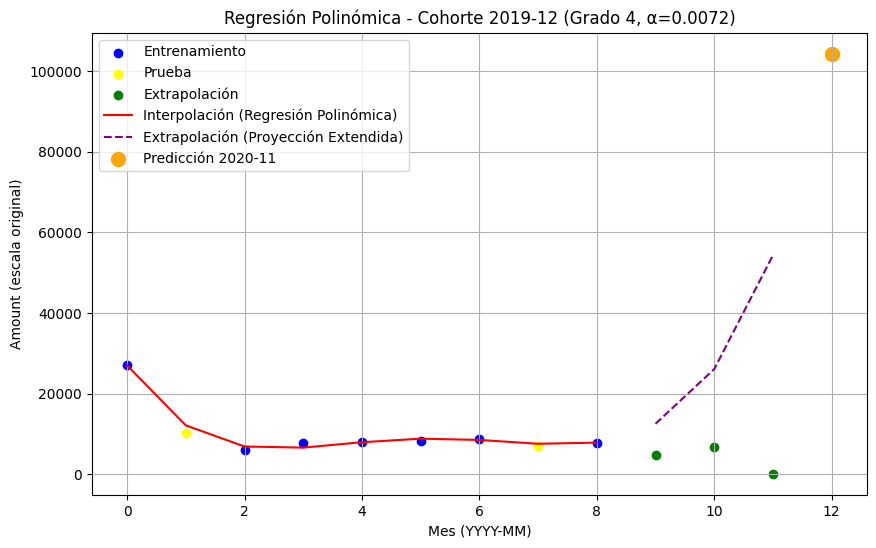

In [57]:
# 1️⃣ Aplicar la transformación logarítmica en 'amount'
cohorte_2019_12_log = np.log1p(cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].dropna())

# Extract X_numeric and y from the processed cohort_revenue DataFrame
X_numeric = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12'].index.values.reshape(-1, 1)
y = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].values


# 3️⃣ Separar 80% interpolación y 20% extrapolación
split_idx = int(len(X) * 0.80)
X_interp, X_extrap = X_numeric[:split_idx], X_numeric[split_idx:]
y_interp, y_extrap = y[:split_idx], y[split_idx:]

# 4️⃣ Dentro del 80% de interpolación, dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.20, random_state=42)

# 5️⃣ Ajustar modelo de regresión polinómica con Ridge para evitar sobreajuste
degree = 4  # Se puede probar con otros grados
alpha = 0.0072  # Regularización

poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_interp_poly = poly.transform(X_interp)
X_extrap_poly = poly.transform(X_extrap)

# 6️⃣ Entrenar modelo con Ridge
model = Ridge(alpha=alpha)
model.fit(X_train_poly, y_train)

# 7️⃣ Generar predicciones
y_interp_pred = model.predict(X_interp_poly)
y_extrap_pred = model.predict(X_extrap_poly)

# 8️⃣ Visualización del gráfico
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='yellow', label='Prueba')
plt.scatter(X_extrap, y_extrap, color='green', label='Extrapolación')
plt.plot(X_interp, y_interp_pred, color='red', label='Interpolación (Regresión Polinómica)')
plt.plot(X_extrap, y_extrap_pred, linestyle='dashed', color='purple', label='Extrapolación (Proyección Extendida)')

# Agregar predicción para el último mes
last_prediction_x = np.array([[X_numeric[-1][0] + 1]])
last_prediction_poly = poly.transform(last_prediction_x)
last_prediction_y = model.predict(last_prediction_poly)
plt.scatter(last_prediction_x, last_prediction_y, color='orange', s=100, label='Predicción 2020-11')

# Formato del gráfico
plt.xlabel('Mes (YYYY-MM)')
plt.ylabel('Amount (escala original)')
plt.title(f'Regresión Polinómica - Cohorte 2019-12 (Grado {degree}, α={alpha})')
plt.legend()
plt.grid(True)
plt.show()

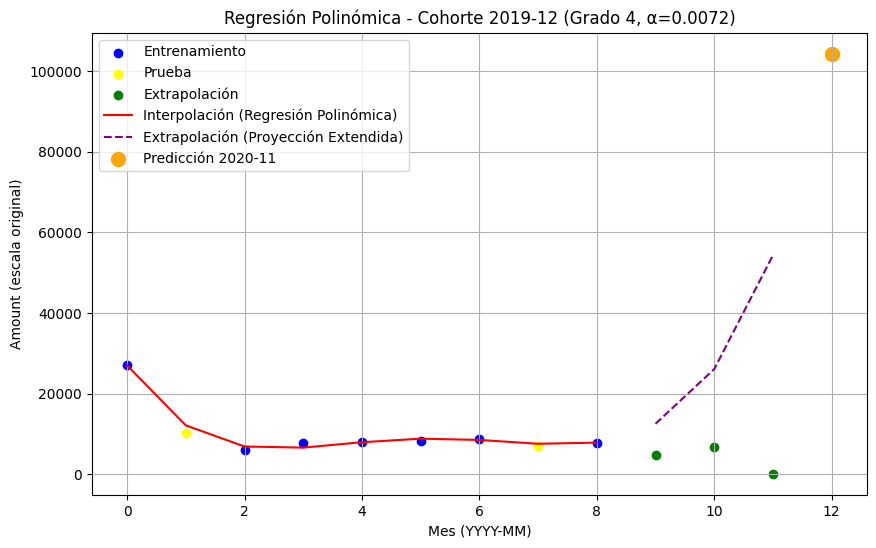

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# 1️⃣ Aplicar la transformación logarítmica en 'amount'
cohorte_2019_12_log = np.log1p(cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].dropna())

# Extraer X_numeric y y del DataFrame procesado
X_numeric = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12'].index.values.reshape(-1, 1)
y = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].values

# Extract X_numeric and y from the processed cohort_revenue DataFrame
X_numeric = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12'].index.values.reshape(-1, 1)
y = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].values

# 3️⃣ Separar 80% interpolación y 20% extrapolación
split_idx = int(len(X_numeric) * 0.80)
X_interp, X_extrap = X_numeric[:split_idx], X_numeric[split_idx:]
y_interp, y_extrap = y[:split_idx], y[split_idx:]

# 4️⃣ Dentro del 80% de interpolación, dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.20, random_state=42)

# 5️⃣ Ajustar modelo de regresión polinómica con Ridge para evitar sobreajuste
degree = 4  # Se puede probar con otros grados
alpha = 0.0072  # Regularización

poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_interp_poly = poly.transform(X_interp)
X_extrap_poly = poly.transform(X_extrap)

# 6️⃣ Entrenar modelo con Ridge
model = Ridge(alpha=alpha)
model.fit(X_train_poly, y_train)

# 7️⃣ Generar predicciones
y_interp_pred = model.predict(X_interp_poly)
y_extrap_pred = model.predict(X_extrap_poly)

# 8️⃣ Visualización del gráfico
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='yellow', label='Prueba')
plt.scatter(X_extrap, y_extrap, color='green', label='Extrapolación')
plt.plot(X_interp, y_interp_pred, color='red', label='Interpolación (Regresión Polinómica)')
plt.plot(X_extrap, y_extrap_pred, linestyle='dashed', color='purple', label='Extrapolación (Proyección Extendida)')

# Agregar predicción para el último mes
last_prediction_x = np.array([[X_numeric[-1][0] + 1]])
last_prediction_poly = poly.transform(last_prediction_x)
last_prediction_y = model.predict(last_prediction_poly)
plt.scatter(last_prediction_x, last_prediction_y, color='orange', s=100, label='Predicción 2020-11')

# Formato del gráfico
plt.xlabel('Mes (YYYY-MM)')
plt.ylabel('Amount (escala original)')
plt.title(f'Regresión Polinómica - Cohorte 2019-12 (Grado {degree}, α={alpha})')
plt.legend()
plt.grid(True)
plt.show()


📊 Resumen estadístico de y_interp:
count     9.000000
mean      9.103978
std       0.440943
min       8.679652
25%       8.942592
50%       8.974745
75%       9.083189
max      10.210899
dtype: float64

📊 Resumen estadístico de y_extrap:
count    3.000000
mean     7.302465
std      2.332607
min      4.615121
25%      6.552060
50%      8.488999
75%      8.646137
max      8.803274
dtype: float64

📈 Correlación entre los últimos 3 puntos de interpolación y primeros 3 de extrapolación:
[[ 1.         -0.03210959]
 [-0.03210959  1.        ]]

📊 Evaluación del Modelo:
RMSE Interpolación: 641.917, RMSE Extrapolación: 263409.986
R² Interpolación: 0.988, R² Extrapolación: -0.682

🔍 Valores negativos en extrapolación:
[]

🔮 Predicción para Noviembre 2020: 36579201.56


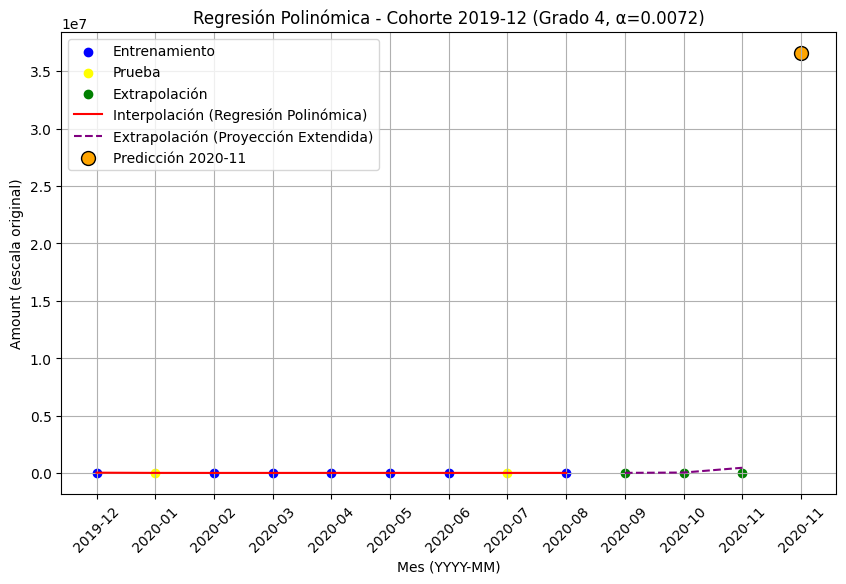

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Aplicar la transformación logarítmica en 'amount'
cohorte_2019_12_log = np.log1p(cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['amount'].dropna())

# 2️⃣ Convertir índices (Mes) a fechas tipo 'YYYY-MM'
# X = pd.to_datetime(cohorte_2019_12_log.index.astype(str), format='%Y-%m')  # ❌ This line might be causing issues

# ✅ Use the index from your original cohort_revenue DataFrame
X = cohort_revenue[cohort_revenue['Cohorte'] == '2019-12'].index.values.reshape(-1, 1)
X = pd.to_datetime(cohort_revenue[cohort_revenue['Cohorte'] == '2019-12']['Mes'].astype(str), format='%Y-%m') # Assuming 'Mes' column contains dates

X_numeric = np.array(range(len(X))).reshape(-1, 1)  # Convertir a índices numéricos para la regresión
y = np.array(cohorte_2019_12_log.values)  # Valores transformados

# 3️⃣ Separar 80% interpolación y 20% extrapolación
split_idx = int(len(X) * 0.80)
X_interp, X_extrap = X_numeric[:split_idx], X_numeric[split_idx:]
y_interp, y_extrap = y[:split_idx], y[split_idx:]

# 📍 Agregar el mes futuro "2020-11"
next_month_numeric = np.array([[X_numeric[-1][0] + 1]])  # El siguiente índice
X_extrap = np.vstack([X_extrap, next_month_numeric])  # Añadir el mes 2020-11 a la extrapolación

# 4️⃣ Dentro del 80% de interpolación, dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X_interp, y_interp, test_size=0.20, random_state=42)

# 📊 Evaluación previa: Distribución de datos
print("📊 Resumen estadístico de y_interp:")
print(pd.Series(y_interp).describe())

print("\n📊 Resumen estadístico de y_extrap:")
print(pd.Series(y_extrap).describe())

# 📈 Correlación entre los últimos puntos de interpolación y primeros de extrapolación
print("\n📈 Correlación entre los últimos 3 puntos de interpolación y primeros 3 de extrapolación:")
print(np.corrcoef(y_interp[-3:], y_extrap[:3]))

# 5️⃣ Ajustar modelo de regresión polinómica con Ridge para evitar sobreajuste
degree = 4  # Se puede probar con otros grados
alpha = 0.0072  # Regularización

poly = PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_interp_poly = poly.transform(X_interp)
X_extrap_poly = poly.transform(X_extrap)

# 6️⃣ Entrenar modelo con Ridge
model = Ridge(alpha=alpha)
model.fit(X_train_poly, y_train)

# 7️⃣ Predicciones
y_interp_pred = model.predict(X_interp_poly)  # Predicciones en interpolación
y_extrap_pred = model.predict(X_extrap_poly)  # Predicciones en extrapolación

# Extraer predicción del mes 2020-11
y_future_pred = y_extrap_pred[-1]

# 8️⃣ Volver a la escala original (deshacer logaritmo)
y_interp_pred = np.expm1(y_interp_pred)
y_extrap_pred = np.expm1(y_extrap_pred)
y_train_orig = np.expm1(y_train)
y_test_orig = np.expm1(y_test)
y_extrap_orig = np.expm1(y_extrap)
y_future_pred_orig = np.expm1(y_future_pred)  # Valor predicho en escala original

# 9️⃣ Evaluación de modelo: RMSE y R²
rmse_interp = np.sqrt(mean_squared_error(y_interp_pred, np.expm1(y_interp)))
rmse_extrap = np.sqrt(mean_squared_error(y_extrap_pred[:-1], y_extrap_orig))  # Excluyendo mes futuro
r2_interp = r2_score(y_interp_pred, np.expm1(y_interp))
r2_extrap = r2_score(y_extrap_pred[:-1], y_extrap_orig)  # Excluyendo mes futuro

print(f"\n📊 Evaluación del Modelo:")
print(f"RMSE Interpolación: {rmse_interp:.3f}, RMSE Extrapolación: {rmse_extrap:.3f}")
print(f"R² Interpolación: {r2_interp:.3f}, R² Extrapolación: {r2_extrap:.3f}")

# 🔍 Ver si hay valores negativos en extrapolación (no deberían existir en Amount)
print("\n🔍 Valores negativos en extrapolación:")
print(y_extrap_pred[y_extrap_pred < 0])

# 🔮 Predicción para noviembre de 2020
print(f"\n🔮 Predicción para Noviembre 2020: {y_future_pred_orig:.2f}")

#  🔄 Convertir los valores numéricos de X a etiquetas de fecha
plt.figure(figsize=(10, 6))

# Datos originales transformados de vuelta
plt.scatter(X_train, y_train_orig, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test_orig, color='yellow', label='Prueba')
plt.scatter(X_extrap[:-1], y_extrap_orig, color='green', label='Extrapolación')

# Líneas de tendencia
plt.plot(X_interp, y_interp_pred, color='red', linestyle='-', label='Interpolación (Regresión Polinómica)')
plt.plot(X_extrap[:-1], y_extrap_pred[:-1], color='purple', linestyle='--', label='Extrapolación (Proyección Extendida)')

# 🔮 Resaltar predicción de noviembre 2020
plt.scatter(next_month_numeric, y_future_pred_orig, color='orange', edgecolors='black', s=100, label='Predicción 2020-11')

# Configuración de la gráfica
plt.xticks(X_numeric.flatten().tolist() + [next_month_numeric[0][0]],
           [d.strftime('%Y-%m') for d in X] + ['2020-11'],  # Format each date in X
           rotation=45)
plt.xlabel("Mes (YYYY-MM)")
plt.ylabel("Amount (escala original)")
plt.title(f"Regresión Polinómica - Cohorte 2019-12 (Grado {degree}, α={alpha})")
plt.legend()
plt.grid(True)
plt.show()